# 1 - ETL Forecast DA & RT LMP's at North Hub Bus
This script executes Extract Transform Load (ETL) processes on time-series and cross-sectional data.  

__Objective:__
Export three .CSV files to the 'data' folder containing clean, complete, reviewed data:
1. 'features.csv' - table indexed by feature name with categorical data
2. 'ts.csv' - out-of-forecast time series data indexed by date
3. 'ts_forecast.csv' - in-forecast time series data indexed by date and missing values

The output files are intended for visualization and modeling that is completed in subsequent Jupyter notebooks (this is step 1 of the complete process).

__Source(s):__
(1) MS Excel file with two worksheets containing time-series data and tabular data.  

  
__Big Picture:__
The objective of the larger process is to generate hourly forecasts of the $/MWh Local Marginal Price (LMP) on the Day-Ahead (DA) and Real-Time (RT) markets.

Price forecasting will be generated for the "ERCOT North Hub" location, and data for various Independent System Operators(ISO) is considered.

__Workflow:__
The process is divided in to the following sequence of notebooks (.ipynb format):

 * 1 - ETL - DA & RT LMP Forecast
 * 2 - Descriptive Statistics & Data Augmentation
 * 3 - Stationarity and Seasonality
 * 4 - ARIMA Time Series Models
 * 5 - ARCH_GARCH_models

The data used in this analysis is from January 1, 2022 through August 19, 2022.  The source data contains 5519 records with 47 columns and a datetime index, and includes null data points.  The data are almost entirely numeric. 

The script was originally written to handle a specific dataset.  However, it is built with flexibility that should permit the use of variable sets of time series and feature tabular data as long as they use the same structure as the original dataset.

Limitations
* The script does not identify trading strategies or any other application of the forecast
* The forecast algorithms are trained on less than one year of data and may not be adequately informed to forecast periods years in the future without training on newer data.

Copyright Matt Chmielewski<BR>
December 6, 2024<BR>
https://github.com/emskiphoto

## Objectives - Forecast DA & RT LMP's at North Hub Bus

1. Data management/ETL
2.  Data augmentation (linear/non-linear properties)
3.  Descriptive statistics (4 moments) and distribution characteristics (normal, lognormal, gamma etc.) of the target variable
4.  Correlation Analysis and/or Principle Component Analysis (PCA)
5.  Feature selection
6.  Time series/cross sectional modeling (Regressions/Classifications)
7.  Cross validation
8.  Model selection via backtesting performance in Statistical terms (R2, MSE/MAE, Recall and Precision, confusion matrix etc.).

### Assumptions:
1. All time series data has been adjusted to the same time zone (presumably Central Standard Time - 'timezone')
2. All Pricing data is in the same unit, US Dollars.
3. All data is reported in consistent units.  For example, energy pricing is all in $/MWh, demand is always reported as MW.
4. Trading frequency is hourly
5. Singular hourly prices adequately represent the range of accepted bids & offers that occurred each hour.


### Trading Considerations (Not in scope of current project):

Trading:

1.	In terms of trading strategies, which of the following approaches should I consider:
2.	Buy electricity long at DALMP and sell at RTLMP within 24 hours?
3.	AND/OR Sell electricity short at DALMP and buy at RTLMP within 24 hours?

Risk-Reward profile:

1.	Frequent, low-risk, lower profit trades for safe & steady revenue.
2.	Infrequent, high-risk, high profit for signficant & inconsistent revenue

Trading Assumptions:
1.	No commission fees or taxes
2.	Bid-Ask spread is always zero (ie., doesn’t exist)
3.	No Congestion costs/losses.
4.	Cash trading, no margin/financing used and therefore no interest expenses.
5.	Profit/Loss is calculated as full difference between purchase price and market sale price at time of sale.  For example if a unit of energy was bought at 100 and sold at 110, the full 10 is recognized as profit (ie., the 10 is not reduced by bid-ask spreads, discounts, or sales at lower-than-market pricing executed to guarantee safe/quick trade exit). 

Ref:  https://blog.yesenergy.com/yeblog/how-power-trading-works#:~:text=Essentially%2C%20traders%20must%20buy%20back%20any%20power,spread)%20the%20measure%20of%20a%20trade's%20profitability.

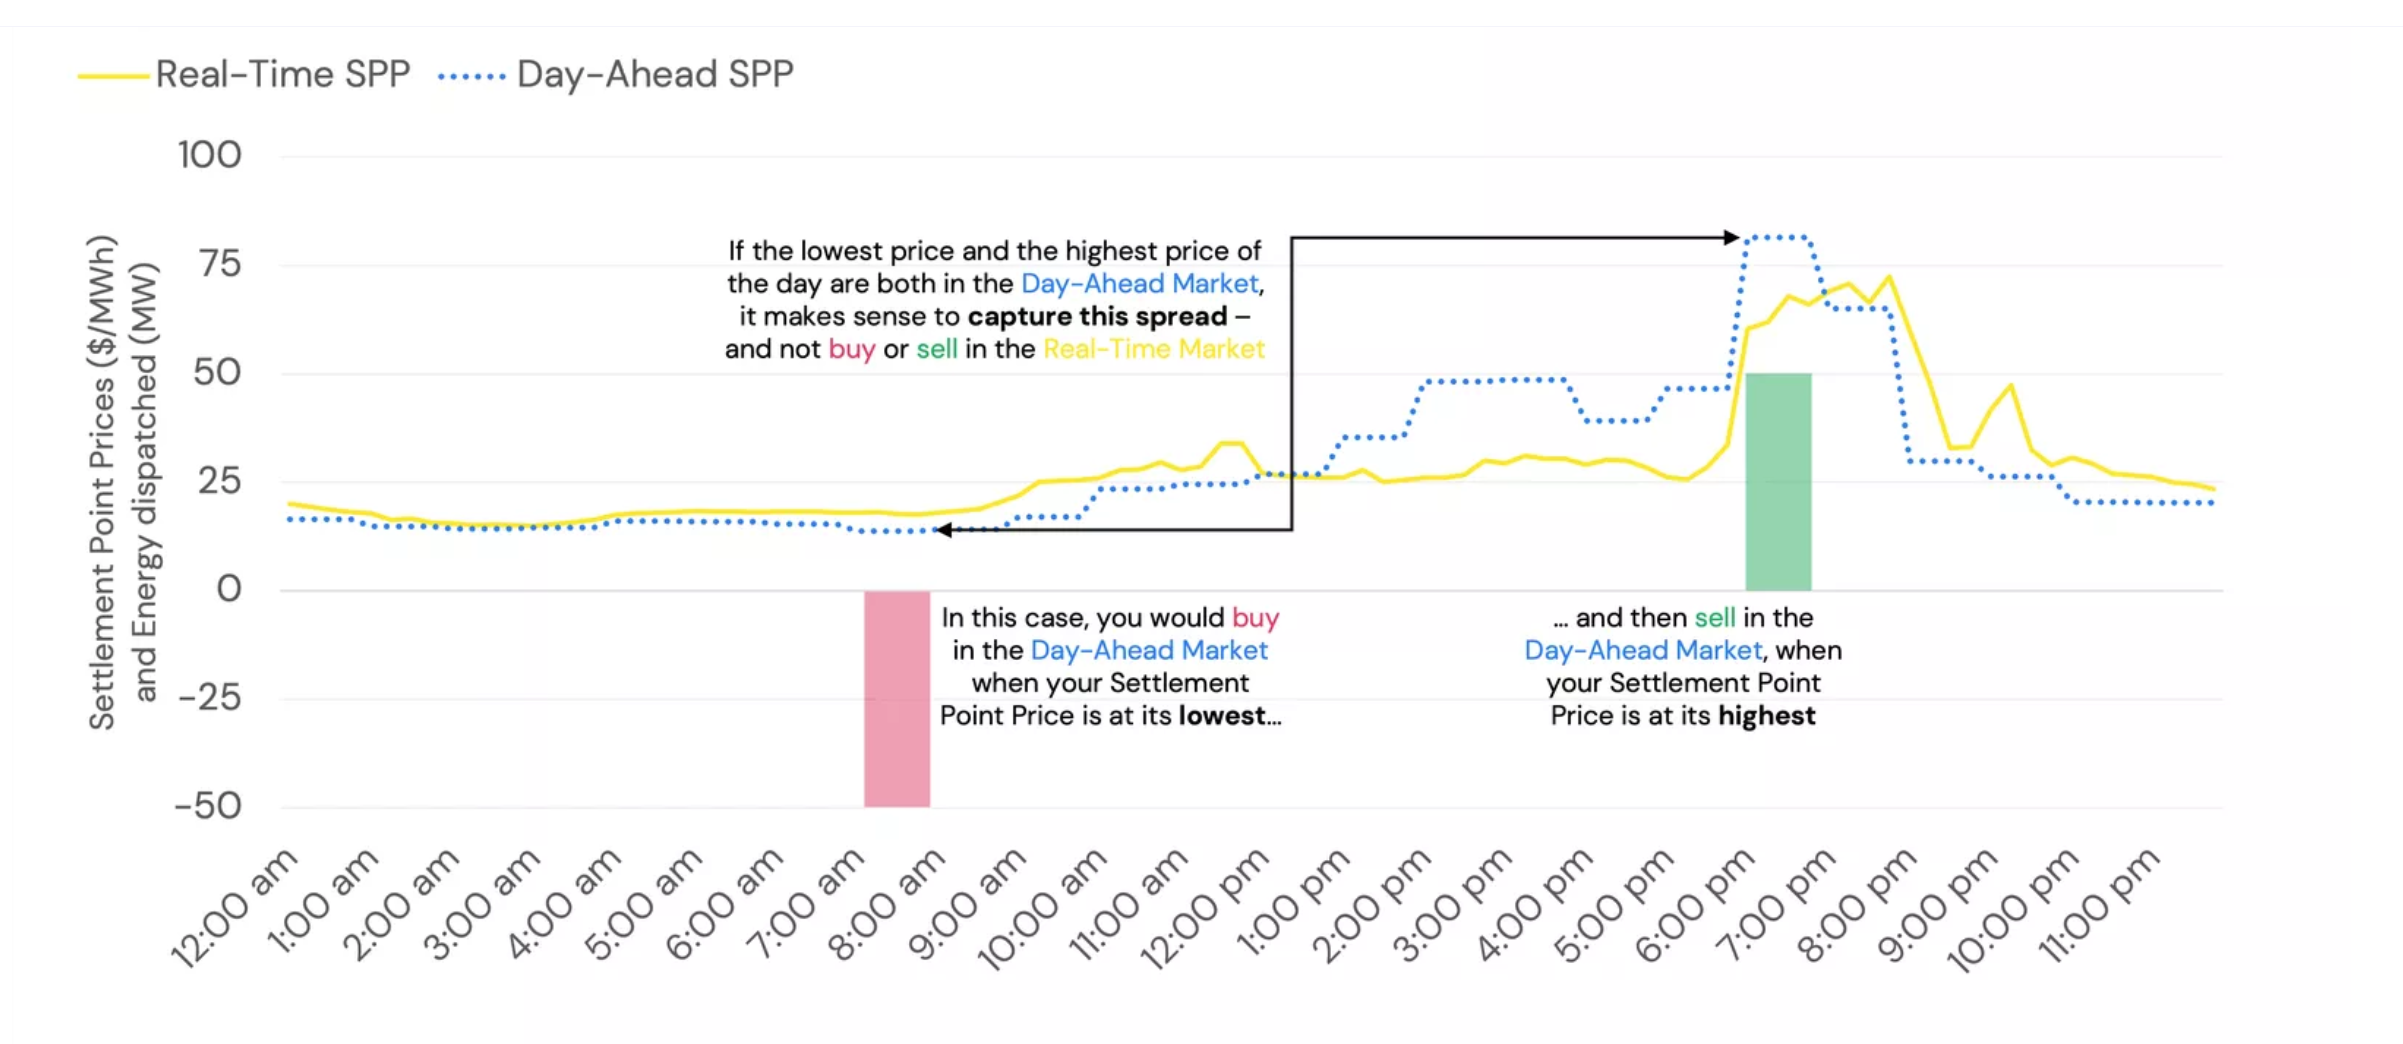

### ERCOT North hub Considerations
The geographical location of the pricing hub is relevant to MWh pricing.  The North Hub Bus is located in central Texas on the southern border of the United States of America. It is part of ERCOT which is an Independent System Operator (ISO) that has 1,250 generation units and 54,100 miles of transmission lines.  ERCOT is interconnected with multiple ISO's across the USA and is therefore able to buy and sell electricity with other ISOs.  However, this interconnection is limited to other intra-ISO connections.  In general, the greater the distance between the supplier and consumer of electricity the less competitive the cost per MWh.   __It is expected that features that are geographically closer to the North Hub will be more effective in forecasting future prices.__<BR>
    
https://www.pcienergysolutions.com/2024/05/22/ercot-hubs-and-load-zones-a-look-at-the-impact-of-texas-energy-market/
https://www.eia.gov/electricity/wholesale/
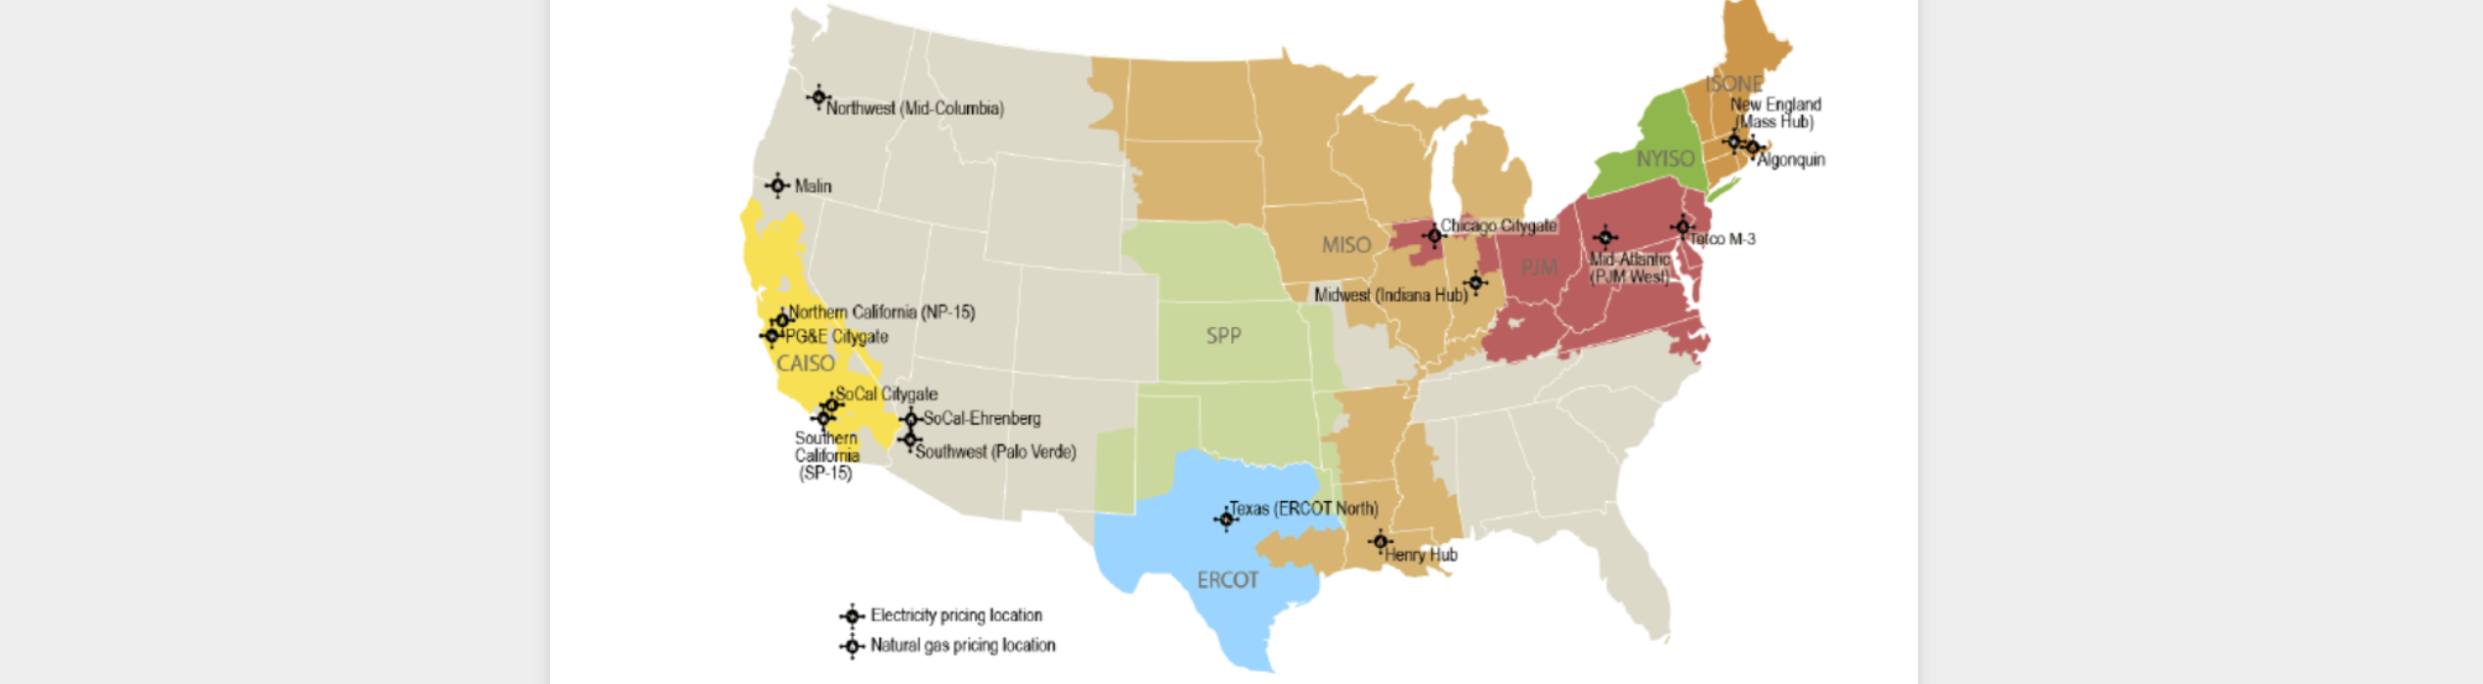

### References:
https://www.ercot.com/files/docs/2022/01/28/2022_02%20Wholesale%20101.pdf
https://www.ercot.com/files/docs/2007/05/18/060nprr_02_prs_recommendation_report_051707.doc
    

### Future Improvements:
1. More data with more features
    * auction data
    * weather data
    * energy storage data
    * economic data
    * etc.
    
2. More data covering more time
3. Energy Transmission & Market simulation (https://github.com/rwl/pyreto, https://github.com/rwl/pylon, etc.)
4. Automatic creation of a config.py file and parameters for downstream visualization and analysis.
5. Outlier detection and resolution.

## Load Python Dependencies

In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# load all parameters from custom config.py file
from config import *
# load all custom functions from util.py file
from utils import *
%config IPCompleter.use_jedi=False

## Locations
This displays filepaths to a standard folder structure that are created and stored in the config.py file.

In [2]:
data_dir, model_dir

(WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data'),
 WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/model'))

## Parameters
Most Parameters are defined in the config.py file located in 'code' directory.  Parameters are generally defined during the development of this and other scripts.

In [3]:
print(f'Timezone: {timezone}')
print(f'Maximum fraction of all records containing any NaN value:  {max_fraction_nan}')
print(f'maximum number of consecutive NaN values allowed to be imputed via interpolatation:  {n_max_consec_nans_interp}')

Timezone: US/Central
Maximum fraction of all records containing any NaN value:  0.05
maximum number of consecutive NaN values allowed to be imputed via interpolatation:  4


## Extract Transform Load Data (ETL)
Two unique dataframes will be extracted from the Excel source file.
* 'Features' --> df_features
* 'Data' --> df

### Load Feature data from "POC Sample Data.xlsx" 
Feature data should be provided as a worksheet called 'Features' within an Excel workbook.  Only the header and rows with a unique Feature name will be retained in processing.  

Call the dataframe 'df_features'.  This is a simple table with information on content and categorization of each feauture (column) in the time-series dataset.
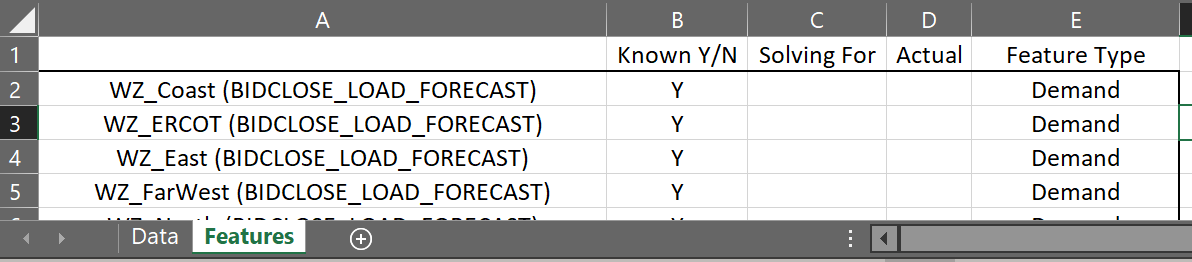
A test version ('POC Sample Data_test.xlsx') of the original file is available.  It has additional columns containing bad/mixed/incomplete data.

In [4]:
# current source file and test version of source file
file_source, file_source_test

(WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data/POC Sample Data.xlsx'),
 WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data/POC Sample Data_test.xlsx'))

In [5]:
sheet_features = 'Features'
df_features = pd.read_excel(file_source, sheet_name=sheet_features)
# df_features = pd.read_excel(file_source_test, sheet_name=sheet_features)  # for testing
df_features.head(3)

Unnamed: 0 Known Y/N Solving For Actual Feature Type
0  WZ_Coast (BIDCLOSE_LOAD_FORECAST)         Y         NaN    NaN       Demand
1  WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)         Y         NaN    NaN       Demand
2   WZ_East (BIDCLOSE_LOAD_FORECAST)         Y         NaN    NaN       Demand

#### Quality Check of df_features

In [6]:
# are there duplicate indices?
assert not df_features.index.has_duplicates
# are there duplicate column names?
assert not df_features.columns.has_duplicates

In [7]:
# any records that are duplicated?
df_features.loc[df_features.duplicated(keep=False)]

Empty DataFrame
Columns: [Unnamed: 0, Known Y/N, Solving For, Actual, Feature Type]
Index: []

In [8]:
# drop duplicated records
display(df_features.shape)
df_features.drop_duplicates(inplace=True)
# designate first column as index and name it Feature
df_features = df_features.set_index(df_features.columns[0])\
                    .rename_axis('Feature')
display(df_features.shape)

(42, 5)

(42, 4)

In [9]:
df_features.sample(5)

Known Y/N Solving For Actual  \
Feature                                                                 
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)         Y         NaN    NaN   
WEST_NORTH (WIND_STWPF_BIDCLOSE)                 Y         NaN    NaN   
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)              Y         NaN    NaN   
GR_ERCOT (WINDDATA)                            NaN         NaN      x   
WZ_Coast (BIDCLOSE_LOAD_FORECAST)                Y         NaN    NaN   

                                         Feature Type  
Feature                                                
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)       Demand  
WEST_NORTH (WIND_STWPF_BIDCLOSE)                 Wind  
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)            Demand  
GR_ERCOT (WINDDATA)                              Wind  
WZ_Coast (BIDCLOSE_LOAD_FORECAST)              Demand

#### Visualize Feature Counts by Type

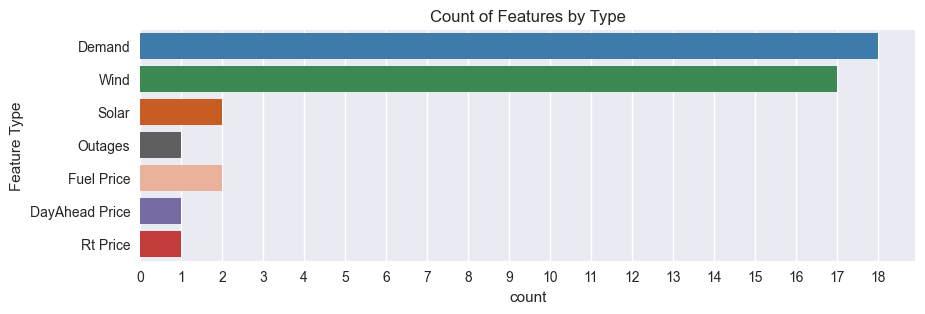

In [10]:
fig, ax = plt.subplots(figsize=(10,3))
sns.countplot(data=df_features, y='Feature Type', hue='Feature Type',
              palette=feature_type_colors, dodge=False, ax=ax)
features_counts_ = df_features['Feature Type'].value_counts()
n_features = df_features['Feature Type'].nunique()
ax.set(xticks=range(features_counts_.max() +1),
       xticklabels=map(str, range(features_counts_.max()+1)))
ax.legend([])
ax.set_title('Count of Features by Type')
plt.show()

#### Fill NaNs and convert columns to boolean

In [11]:
# custom function
def cols_w_lt_n_unique_vals(df, n=3):
    """Returns index of only column names whose
    series has no more than 'n' unique values.  This can 
    be used to identify columns suited for boolean dtype."""
    return df.columns[df.apply(pd.Series.nunique) <= n-1]

In [12]:
# Fill NaN with False
df_features.fillna(False, inplace=True)
# identify columns that can be boolean dtype
cols_bool = cols_w_lt_n_unique_vals(df_features)
# make all values that aren't False to be True
for col_ in cols_bool:
    df_features[col_] = df_features[col_].mask(
        df_features[col_] != False, True)\
        .astype(bool)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, WZ_Coast (BIDCLOSE_LOAD_FORECAST) to ERCOT (GENERATION_SOLAR_RT)
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Known Y/N     42 non-null     bool  
 1   Solving For   42 non-null     bool  
 2   Actual        42 non-null     bool  
 3   Feature Type  42 non-null     object
dtypes: bool(3), object(1)
memory usage: 1.8+ KB


#### Add 'Category' to df_features
To facilitate filtering by Feature Category, ie "BIDCLOSE_LOAD_FORECAST", "RTLOAD", etc.

In [13]:
df_features['Category'] = [x.split(" (")[-1].split(")")[0] for 
                           x in df_features.index]
df_features['Category'].sample(5).to_frame()

Category
Feature                                                         
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)         BIDCLOSE_LOAD_FORECAST
WZ_West (BIDCLOSE_LOAD_FORECAST)          BIDCLOSE_LOAD_FORECAST
WZ_ERCOT (RTLOAD)                                         RTLOAD
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  BIDCLOSE_LOAD_FORECAST
GR_COASTAL (WINDDATA)                                   WINDDATA

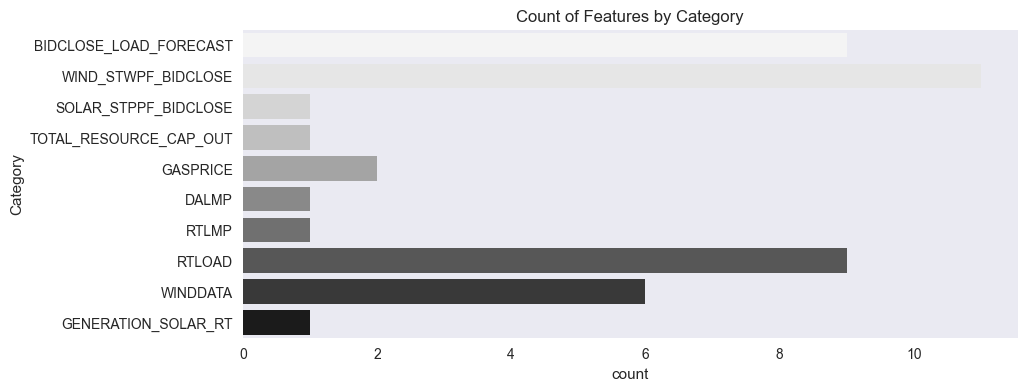

In [14]:
plt.figure(figsize=(10,4))
sns.countplot(data=df_features, y='Category', hue='Category',
              palette='Greys', dodge=False)
plt.legend([])
plt.grid(axis='x')
plt.title('Count of Features by Category')
plt.show()

#### Add 'Region' to df_features

In [15]:
# custom function
def region_from_feature(x):
    """Returns list of strings from x where the second term
    (ex. 'WZ_SouthCentral (RTLOAD)'  --> SouthCentral) is extracted
    from strings matching the example format.  If no value is found to
    be extracted, 'None' is returned"""
    return list([term.split("_")[1].split(" ")[0]\
            .lower().strip() 
            if len(term.split("_")) != 1
           else None for term in x])

In [16]:
df_features['Region'] = [str(x).replace('southern', 'south')\
                         .replace('coastal', 'coast') for
                         x in region_from_feature(df_features.index)]
df_features['Region'].to_frame().sample(5)

Region
Feature                                      
NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)     stwpf
Katy (GASPRICE)                          None
ERCOT (TOTAL_RESOURCE_CAP_OUT)       resource
HB_NORTH (RTLMP)                        north
ERCOT (GENERATION_SOLAR_RT)             solar

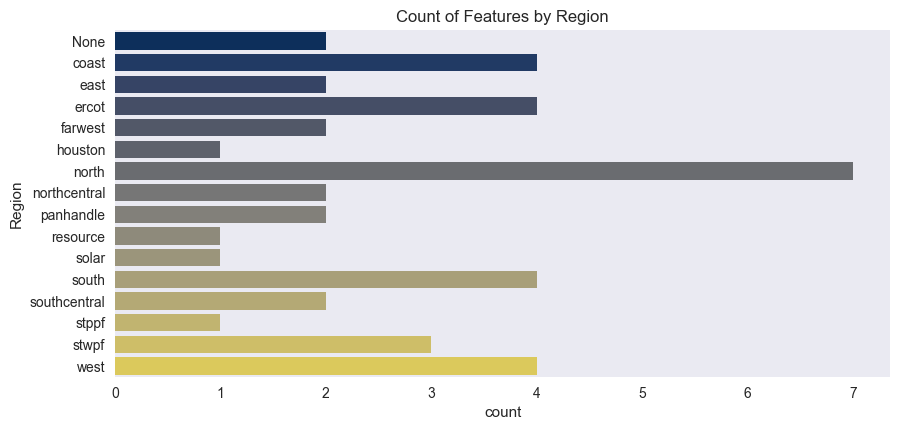

In [17]:
plt.figure(figsize=(10,4.5))
sns.countplot(data=df_features.sort_values('Region'),
              y='Region', hue='Region',
              palette='cividis', dodge=False)
plt.legend([])
plt.grid(axis='x')
plt.title('Count of Features by Region')
plt.show()

In [18]:
df_features.tail().T

Feature      GR_NORTH (WINDDATA) GR_PANHANDLE (WINDDATA) GR_SOUTH (WINDDATA)  \
Known Y/N                  False                   False               False   
Solving For                False                   False               False   
Actual                      True                    True                True   
Feature Type                Wind                    Wind                Wind   
Category                WINDDATA                WINDDATA            WINDDATA   
Region                     north               panhandle               south   

Feature      GR_WEST (WINDDATA) ERCOT (GENERATION_SOLAR_RT)  
Known Y/N                 False                       False  
Solving For               False                       False  
Actual                     True                        True  
Feature Type               Wind                       Solar  
Category               WINDDATA         GENERATION_SOLAR_RT  
Region                     west                       solar

### Designate colors for each feature
Feature to color assignments are already saved in config file.  The steps below can be used for initial 'colors_features' dictionary creation.

In [19]:
# List of matplotlib colormaps to be assigned to each feature type.
# each feature with each feature_type will be assigned a color extracted from the
# assigned feature_type 'cmap'
# to see list of cmaps:  dir(plt.cm)
print(cmap_selection)

['Blues', 'Greens', 'Oranges', 'Greys', 'coolwarm', 'Purples', 'Reds', 'Viridis', 'Viridis', 'Viridis']


In [20]:
# cmap to feature_type assignments saved in feature_cmap dictionary ('config.py')
feature_cmap

{'Demand': <matplotlib.colors.LinearSegmentedColormap at 0x164439a87f0>,
 'Wind': <matplotlib.colors.LinearSegmentedColormap at 0x164439d8400>,
 'Solar': <matplotlib.colors.LinearSegmentedColormap at 0x164439d8460>,
 'Outages': <matplotlib.colors.LinearSegmentedColormap at 0x164439d8fd0>,
 'Fuel Price': <matplotlib.colors.LinearSegmentedColormap at 0x164439d8430>,
 'DayAhead Price': <matplotlib.colors.LinearSegmentedColormap at 0x164439d80d0>,
 'Rt Price': <matplotlib.colors.LinearSegmentedColormap at 0x164439d84c0>}

#### Extract colors from Colormaps by Feature_type and assign to individual feature names

In [21]:
df_features.sort_values(by=['Feature Type', 'Known Y/N'], inplace=True)

In [22]:
colors = []
for feature_ in df_features['Feature Type'].unique():
    print(feature_)
    idx_feature_ = df_features.loc[df_features['Feature Type'] == feature_]\
                    .index.tolist()
    n_colors = len(idx_feature_)
#     print(n_colors)
    colors_ = [plt.get_cmap(feature_cmap[feature_])(idx_) for
                   idx_ in np.linspace(0.4,0.99, num=n_colors)]
    colors.extend(colors_)
    
assert len(colors) == df_features.index.nunique()

DayAhead Price
Demand
Fuel Price
Outages
Rt Price
Solar
Wind


In [23]:
df_features['color'] = colors
df_features['color'].sample(5).to_frame()

color
Feature                                                                             
ERCOT (GENERATION_SOLAR_RT)        (0.9921568627450981, 0.6564705882352941, 0.382...
WZ_North (BIDCLOSE_LOAD_FORECAST)  (0.05021145713187236, 0.341760861207228, 0.630...
ERCOT (WIND_STWPF_BIDCLOSE)        (0.25725490196078427, 0.6717416378316032, 0.36...
GR_ERCOT (WINDDATA)                (0.5462514417531719, 0.8112572087658593, 0.537...
GR_NORTH (WIND_STWPF_BIDCLOSE)     (0.15294117647058825, 0.5618300653594771, 0.28...

#### Create or Verify colors_features dictionary
contains color assignment for each feature

In [24]:
# on first run, define feature-to-color assignments otherwise,
# verify that the current colors_features dict matches what
# would be generated with the current dataset
try:
    isinstance(colors_features, dict)
# does the feature-to-color assignment generated automatically here match the 
# pre-defined assignments stored in config.py?
    assert colors_features == df_features['color'].to_dict()
except:
    print("Creating new colors_features dictionary - save to config.py")
    colors_features = df_features['color'].to_dict()

In [25]:
# custom function to return color by feature name or grey if name is not in colors_features 
def colors_from_dict(d, features, color_missing = 'grey'):
    """Returns list of RGBA colors of equal length to input features list based on
    feature to color assignments in input dictionary d"""
    rgba_missing = mpl.colors.to_rgba(color_missing)
    return [d[col] if col in d else rgba_missing for col in features]

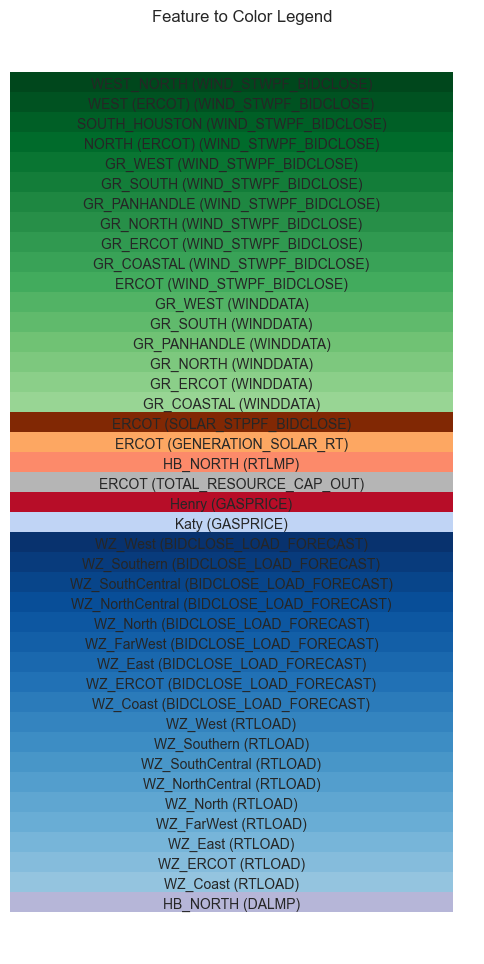

In [26]:
def visualize_color_by_dictionary(d, figsize=(6, 12), title=''):
    """Returns plot of stack of bars with labels from keys in dictionary 'd', colored by
    RGBA color tuple in values of d."""
    fig, ax = plt.subplots(figsize = figsize)
    for idx, (f, c) in zip(range(len(d.keys())), d.items()):
    #     print(idx, f, c)
        ax.barh(idx, 1, color = c, height=1, align='edge')
        ax.text(0.5, idx, f, ha='center', va = 'bottom')
    ax.set_axis_off()
    plt.title(title)
    plt.show()

visualize_color_by_dictionary(colors_features, title= 'Feature to Color Legend')

#### Identify columns by type from df_features

In [27]:
assert cols_target == df_features.index[df_features['Solving For']].tolist()
cols_target = df_features.index[df_features['Solving For']].tolist()
cols_target

['HB_NORTH (DALMP)', 'HB_NORTH (RTLMP)']

#### Quality Check df_features and save to disk

In [28]:
# are there any null values?
assert df_features.notnull().any().any()
assert not df_features.index.has_duplicates

# save to disk
file_features_out = data_dir / 'features.csv'
df_features.to_csv(file_features_out)
assert file_features_out.is_file()
print(f'Augmented & processed features table saved to'
      f':\n{file_features_out}')

Augmented & processed features table saved to:
C:\Users\user\OneDrive\python_envs\ERCOT_electricity_price_forecast\data\features.csv


### Load Time-Series data from "POC Sample Data.xlsx" file as 'df'
Source data is expected to come from a worksheet named 'Data' in and Excel workbook.   Data should have a datetime index in the first column named 'DATETIME'.  Only columns with names will be processed.  Columns with missing numeric data with will be interpolated.  Interpolation will only be applied if a column's fraction of NaN values is less than 'max_fraction_nan' and  a maximum of "n_max_consec_nans_interp" consecutive NaN's will be filled by interpolatation.

This script parses categories from the "(WIND_STWPF_BIDCLOSE)" section of the column name.  However, it's recommended that categories and tags be added as a column using True/False values or a collection of categorical values. 
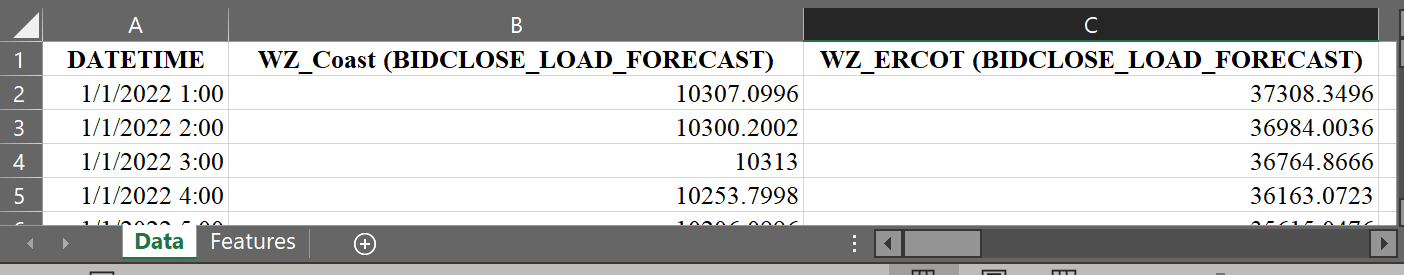
A test version ('POC Sample Data_test.xlsx') of the original file is available. It has additional columns containing bad/mixed/incomplete data.

In [29]:
sheet_ts = 'Data'
# assumed that time series are all reported in the correct time zone
df = pd.read_excel(file_source, sheet_name=sheet_ts, 
               parse_dates=['DATETIME'], index_col='DATETIME')
# df = pd.read_excel(file_source_test, sheet_name=sheet_ts, 
#                parse_dates=['DATETIME'], index_col='DATETIME')  # for testing
df.head(3)

WZ_Coast (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                 
2022-01-01 01:00:00                         10307.0996   
2022-01-01 02:00:00                         10300.2002   
2022-01-01 03:00:00                         10313.0000   

                     WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                 
2022-01-01 01:00:00                         37308.3496   
2022-01-01 02:00:00                         36984.0036   
2022-01-01 03:00:00                         36764.8666   

                     WZ_East (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                
2022-01-01 01:00:00                           1282.52   
2022-01-01 02:00:00                           1260.64   
2022-01-01 03:00:00                           1245.84   

                     WZ_FarWest (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                   
2022-01-01 01:00:00                            3657.7300   
2022-01-01 02:00:00                            3660.2400   
2022-01-01 03:00:00                            3668.4399   

                     WZ_North (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                 
2022-01-01 01:00:00                            819.630   
2022-01-01 02:00:00                            759.254   
2022-01-01 03:00:00                            725.907   

                     WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                        
2022-01-01 01:00:00                                10433.5000   
2022-01-01 02:00:00                                10346.5996   
2022-01-01 03:00:00                                10346.5996   

                     WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                        
2022-01-01 01:00:00                                 6365.8901   
2022-01-01 02:00:00                                 6287.0098   
2022-01-01 03:00:00                                 6146.4502   

                     WZ_Southern (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                    
2022-01-01 01:00:00                             2852.1899   
2022-01-01 02:00:00                             2842.3000   
2022-01-01 03:00:00                             2785.6599   

                     WZ_West (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                
2022-01-01 01:00:00                           1589.79   
2022-01-01 02:00:00                           1527.76   
2022-01-01 03:00:00                           1532.97   

                     ERCOT (WIND_STWPF_BIDCLOSE)  \
DATETIME                                           
2022-01-01 01:00:00                      16698.4   
2022-01-01 02:00:00                      17210.4   
2022-01-01 03:00:00                      18276.7   

                     GR_COASTAL (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                
2022-01-01 01:00:00                            4360.7   
2022-01-01 02:00:00                            4370.5   
2022-01-01 03:00:00                            4357.7   

                     GR_ERCOT (WIND_STWPF_BIDCLOSE)  \
DATETIME                                              
2022-01-01 01:00:00                         16698.4   
2022-01-01 02:00:00                         17210.4   
2022-01-01 03:00:00                         18276.7   

                     GR_NORTH (WIND_STWPF_BIDCLOSE)  \
DATETIME                                              
2022-01-01 01:00:00                           772.5   
2022-01-01 02:00:00                           687.6   
2022-01-01 03:00:00                           683.3   

                     GR_PANHANDLE (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                  
2022-01-01 01:00:00                              3717.1   
2022-01-01 02:00:00                      

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5519 entries, 2022-01-01 01:00:00 to 2022-08-19 00:00:00
Data columns (total 47 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   WZ_Coast (BIDCLOSE_LOAD_FORECAST)         5519 non-null   float64       
 1   WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)         5519 non-null   float64       
 2   WZ_East (BIDCLOSE_LOAD_FORECAST)          5519 non-null   float64       
 3   WZ_FarWest (BIDCLOSE_LOAD_FORECAST)       5519 non-null   float64       
 4   WZ_North (BIDCLOSE_LOAD_FORECAST)         5519 non-null   float64       
 5   WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  5519 non-null   float64       
 6   WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  5519 non-null   float64       
 7   WZ_Southern (BIDCLOSE_LOAD_FORECAST)      5519 non-null   float64       
 8   WZ_West (BIDCLOSE_LOAD_FORECAST)          5519 non-null   float64       

#### Quality Check df

In [31]:
# initial quality check
assert not df.index.has_duplicates
assert not df.columns.has_duplicates

In [32]:
# Backup the original data just in case
df_backup = df.copy()

#### Check which time-series columns are identified in 'Features' table
Efforts will be made to include all features, even if they are missing from the df_features table.  However, if feature is missing from df_features and contains NaN's that are difficult to resolve that column will be dropped from dataset.

In [33]:
# list of features found in df and df_features
features_matched = df.columns.intersection(df_features.index).tolist()
# list of features found in df but NOT in df_features
features_not_matched = df.columns.difference(df_features.index).tolist()
print(f'These features are in the Time Series data but not Features data:\n'
      f'{", ".join(features_not_matched)}')

These features are in the Time Series data but not Features data:
HOURENDING, MARKETDAY, MONTH, PEAKTYPE, YEAR


#### Drop Columns with no Name (ie., 'Unnamed: ')
These columns may or may not have valid data.  Without a name it is difficult to determine what information the column might hold.

In [34]:
cols_unnamed = [col for col in df.columns if col.lower().startswith('unnamed: ')]
print(f'These Unnamed columns will be dropped from df:\n{", ".join(cols_unnamed)}')
df.drop(columns=cols_unnamed, inplace=True)

These Unnamed columns will be dropped from df:



#### Remove duplicated rows & columns

In [35]:
# drop duplicated records
display(df.shape)
df.drop_duplicates(inplace=True)
display(df.shape)

(5519, 47)

(5519, 47)

In [36]:
# drop columns whose contents are duplicated in another column, even if column names are different
display(df.shape)
# this may not be efficient for large dataframes
df = df.reset_index().T.drop_duplicates().T.set_index('DATETIME', drop=True)
display(df.shape)

(5519, 47)

(5519, 47)

#### Remove rows & columns that are all NaN values

In [37]:
# drop rows that are all NaN
display(df.shape)
df.dropna(axis=0, how='all', inplace=True)
display(df.shape)

(5519, 47)

(5519, 47)

In [38]:
# drop columns that are all NaN
display(df.shape)
df.dropna(axis=1, how='all', inplace=True)
display(df.shape)

(5519, 47)

(5519, 46)

### Process Datetime Index

#### Did a seasonal time change occur?

In [39]:
date_timechange = df.index[pd.Series(df.index).diff().idxmax()]
pd.Series(df.index).diff().value_counts()

0 days 01:00:00    5517
0 days 02:00:00       1
Name: DATETIME, dtype: int64

In [40]:
print(f'A seasonal time change occurred on {date_timechange}')

A seasonal time change occurred on 2022-03-13 04:00:00


#### If Datime index is timezone naive, define timezone

In [41]:
if df.index.tzinfo == None:
#     if no datetime index is timezone naive, define timezone
    df.index = df.index.tz_localize(timezone, nonexistent='NaT')
print(f'Timezone of current index is {df.index.tzinfo}')
df.index[:2]

Timezone of current index is US/Central


DatetimeIndex(['2022-01-01 01:00:00-06:00', '2022-01-01 02:00:00-06:00'], dtype='datetime64[ns, US/Central]', name='DATETIME', freq=None)

#### Convert Datetime Index to UTC
Pricing data is for the Henry Hub location which is in Texas, USA.  Texas in the US/Central time zone.   Datetime will be converted to UTC time zone to eliminate gaps in datetime indexes that occur during seasonal time changes.

In [42]:
# How many hours will the native timezone be shifted when converting
# to UTC?
start_native = df.index[0]
utc_offset = pd.Timedelta(start_native.utcoffset())
utc_offset_hours = (utc_offset.days*3600*24 + utc_offset.seconds)/3600
print(f'Datetime Index will be shifted {utc_offset_hours} hours when converting '
     f'{timezone} to "UTC" timezone\n')
print(f'For example, "{df.index[0]}" will become '
      f'"{df.index[0].tz_convert(tz="UTC")}"\n')
print(f'and {df.index[-1]} will become '
      f'{df.index[-1].tz_convert(tz="UTC")}')

Datetime Index will be shifted -6.0 hours when converting US/Central to "UTC" timezone

For example, "2022-01-01 01:00:00-06:00" will become "2022-01-01 07:00:00+00:00"

and 2022-08-19 00:00:00-05:00 will become 2022-08-19 05:00:00+00:00


In [43]:
# convert time series from local timezone to UTC
df.index = df.index.tz_convert(tz='UTC')
# get start and end dates
start_dt, end_dt = df.index[0], df.index[-1]
start_dt, end_dt, df.index[:3]

(Timestamp('2022-01-01 07:00:00+0000', tz='UTC'),
 Timestamp('2022-08-19 05:00:00+0000', tz='UTC'),
 DatetimeIndex(['2022-01-01 07:00:00+00:00', '2022-01-01 08:00:00+00:00',
                '2022-01-01 09:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='DATETIME', freq=None))

In [44]:
# Verify that datetime index intervals are all the same (no gaps)
assert pd.Series(df.index).diff().value_counts().shape[0] == 1

In [45]:
# ensure frequency of datetime index is defined
if df.index.freq == None:
    idx = pd.date_range(start=start_dt, end=end_dt, periods=len(df.index))
    freq_inferred = pd.infer_freq(idx)
    df = df.asfreq(freq_inferred)
print(f'Datetime index frequency is "{df.index.freqstr}"')

Datetime index frequency is "H"


#### Add 'forecast' column to time series
This Boolean column will indicate True if the timestamp is from the period to be forecast.  Forecast period is defined as timestamps in the last 30 days of dataset where 80% (arbitrary) of "cols_actual_solve_for" are NaN

The original dataset does not contain values for the target column(s) in the final rows of the dataset. It is understood that these rows are to be forecasted (and are intentionally left missing here).

In [46]:
df_features.loc[df_features['Actual'] | df_features['Solving For'],
               ['Actual', 'Solving For', 'Feature Type']]

Actual  Solving For    Feature Type
Feature                                                         
HB_NORTH (DALMP)              False         True  DayAhead Price
WZ_Coast (RTLOAD)              True        False          Demand
WZ_ERCOT (RTLOAD)              True        False          Demand
WZ_East (RTLOAD)               True        False          Demand
WZ_FarWest (RTLOAD)            True        False          Demand
WZ_North (RTLOAD)              True        False          Demand
WZ_NorthCentral (RTLOAD)       True        False          Demand
WZ_SouthCentral (RTLOAD)       True        False          Demand
WZ_Southern (RTLOAD)           True        False          Demand
WZ_West (RTLOAD)               True        False          Demand
HB_NORTH (RTLMP)              False         True        Rt Price
ERCOT (GENERATION_SOLAR_RT)    True        False           Solar
GR_COASTAL (WINDDATA)          True        False            Wind
GR_ERCOT (WINDDATA)            True        False            Wind
GR_NORTH (WINDDATA)            True        False            Wind
GR_PANHANDLE (WINDDATA)        True        False            Wind
GR_SOUTH (WINDDATA)            True        False            Wind
GR_WEST (WINDDATA)             True        False            Wind

In [47]:
# generate index (list of dates) that 
idx_forecast = df.iloc[-24*30:].index[df.iloc[-24*30:][cols_actual_solve_for]\
    .isna().sum(1) > 0.8 * len(cols_actual_solve_for)]
print(f'Forecast period is from {idx_forecast[0]} to {idx_forecast[-1]}')
idx_forecast[:3], idx_forecast[-3:]

Forecast period is from 2022-08-15 20:00:00+00:00 to 2022-08-19 05:00:00+00:00


(DatetimeIndex(['2022-08-15 20:00:00+00:00', '2022-08-15 21:00:00+00:00',
                '2022-08-15 22:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='DATETIME', freq='H'),
 DatetimeIndex(['2022-08-19 03:00:00+00:00', '2022-08-19 04:00:00+00:00',
                '2022-08-19 05:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='DATETIME', freq='H'))

In [48]:
# if df's index is in in idx_forecast, set as True
df['forecast'] = df.index.isin(idx_forecast)
df['forecast'].value_counts()

False    5437
True       82
Name: forecast, dtype: int64

#### Visualize DA & RT Pricing and Forecast Period

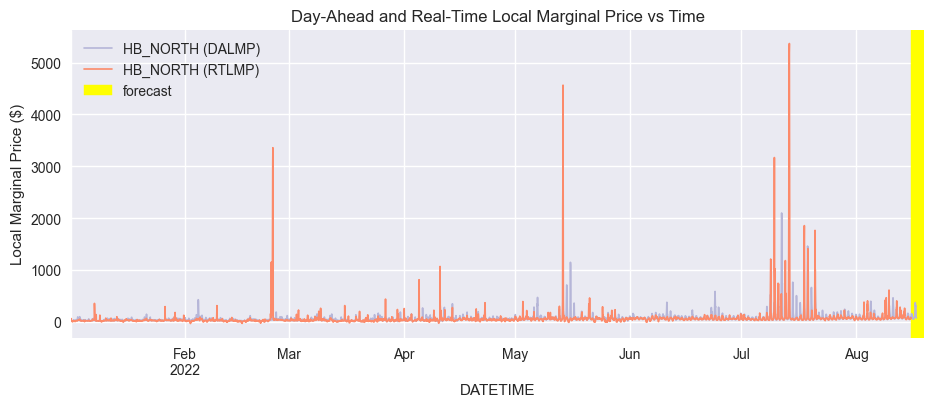

In [49]:
df[cols_target].plot(color=colors_from_dict(colors_features, cols_target),
                     figsize=(11,4), lw=1.2)
plt.axvspan(df.index[df['forecast']][0], df.index[df['forecast']][-1],
            color='yellow', label='forecast')
plt.ylabel('Local Marginal Price ($)')
plt.title('Day-Ahead and Real-Time Local Marginal Price vs Time')
plt.legend()
plt.show()

#### Resolve remaining NaNs
Depending on the proportion of records with any NaNs in the data, NaN's will be imputed using interpolation OR records will be dropped entirely.

As the focus of the analysis is time-series forecasting it is assumed that a complete time series with no gaps and some imputed values is preferred to a incomplete time series with no imputed values.

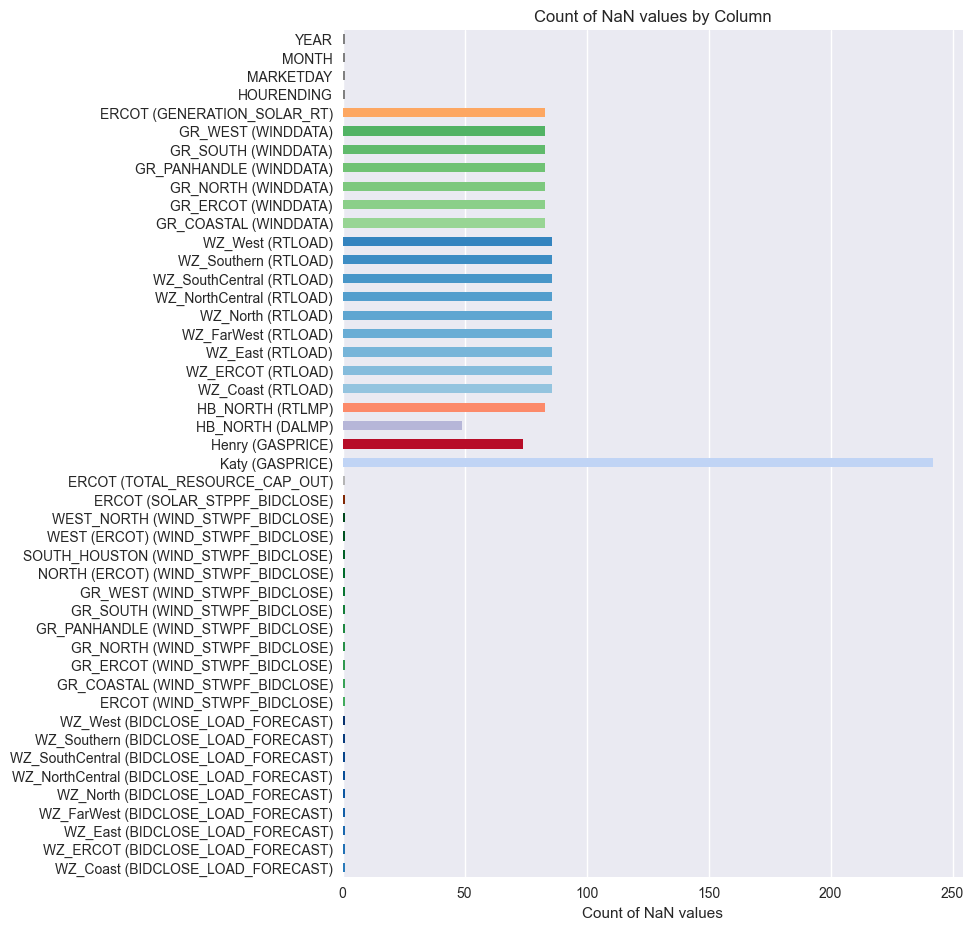

In [50]:
# Does data contain NaNs?
df.isna().sum()[df.isna().sum() > 0].plot.barh(figsize = (8,11),
      color= colors_from_dict(colors_features, df.columns))
plt.title('Count of NaN values by Column')
plt.grid(axis='y')
plt.xlabel('Count of NaN values')
plt.show()

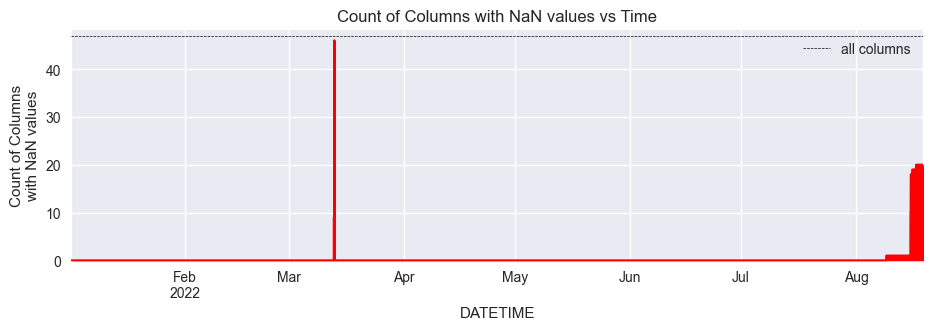

In [51]:
df.isna().sum(axis=1).plot.area(figsize=(11,3), color='red', 
   ylabel='Count of Columns\nwith NaN values',
   title='Count of Columns with NaN values vs Time')
plt.axhline(df.shape[1], color='black', linestyle='--', lw=0.5, label='all columns')
plt.legend()
plt.show()

In [52]:
# # For comparison, what is the mean of columns with NaN
# # prior to having NaN values filled by interpolation?
cols_w_nan = df.columns[df.isna().any(axis=0)].tolist()
# # df.columns[df.isna().any(axis=0)]
# df.loc[:, cols_w_nan].mean().round(1)
# # df[[cols_w_nan]].mean().round(1)
# df[cols_w_nan].apply(lambda x: pd.to_numeric(x.dropna()).mean())

#### Create 'DATETIME_LOCAL' column

In [53]:
# what is the timestamp in local timezone?  Convert UTC index to local timezone and save for reference
# this column is needed for proper labeling of local hour, day, etc.
df['DATETIME_LOCAL'] = df.index.tz_convert(tz=timezone)
df['DATETIME_LOCAL'].to_frame().sample(3).sort_index()

DATETIME_LOCAL
DATETIME                                           
2022-02-19 05:00:00+00:00 2022-02-18 23:00:00-06:00
2022-02-22 21:00:00+00:00 2022-02-22 15:00:00-06:00
2022-07-20 06:00:00+00:00 2022-07-20 01:00:00-05:00

#### Fill NaN values in "Time" columns
Each of these columns requires different filling methods than values that can be interpolated.

In [54]:
# Which columns are involved?  Identify time-related columns
cols_time = df.columns.intersection(['HOURENDING', 'MARKETDAY', 'MONTH', 'YEAR']).tolist()
cols_time = ['DATETIME_LOCAL'] + cols_time

#### Redefine 'HOURENDING', 'MONTH', 'YEAR', 'MARKETDAY' after conversion to UTC
Normally these additional features would be added in the next notebook, but since these came with the initial dataset they are re-created here.

In [55]:
df['HOURENDING'] = df['DATETIME_LOCAL'].dt.hour.astype(int)
df['MONTH'] = df['DATETIME_LOCAL'].dt.month_name().str.upper()
df['YEAR'] = df['DATETIME_LOCAL'].dt.year.astype(int)
df['MARKETDAY'] = df['DATETIME_LOCAL'].dt.strftime("%Y-%m-%d")
df[cols_time].sample(3).sort_index()

DATETIME_LOCAL  HOURENDING   MARKETDAY  \
DATETIME                                                                      
2022-01-26 09:00:00+00:00 2022-01-26 03:00:00-06:00           3  2022-01-26   
2022-06-19 20:00:00+00:00 2022-06-19 15:00:00-05:00          15  2022-06-19   
2022-08-15 21:00:00+00:00 2022-08-15 16:00:00-05:00          16  2022-08-15   

                             MONTH  YEAR  
DATETIME                                  
2022-01-26 09:00:00+00:00  JANUARY  2022  
2022-06-19 20:00:00+00:00     JUNE  2022  
2022-08-15 21:00:00+00:00   AUGUST  2022

In [56]:
# verify that time columns do not have any NaNs
assert df[cols_time].notnull().any().any()

### Resolve NaN Values

#### Interpolate missing numeric values

In [57]:
# list of columns that are NOT time-related content
cols_not_time = df.columns.difference(cols_time)

In [58]:
# If current count of records with any NaN's is below max_fraction_nan, interpolate NaN values 
# for all columns in cols_not_time
n_records_nan = df.isna().any(axis=1).sum()
nan_proportion_acceptable = (n_records_nan / df.shape[0]
                             < max_fraction_nan)
if nan_proportion_acceptable:
#     interpolate missing numeric values
#     df.interpolate(limit = n_max_consec_nans_interp, inplace=True)
    df[cols_not_time] = df[cols_not_time].interpolate(limit = n_max_consec_nans_interp)

In [59]:
df[cols_w_nan].isna().sum()

WZ_Coast (BIDCLOSE_LOAD_FORECAST)             1
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)             1
WZ_East (BIDCLOSE_LOAD_FORECAST)              1
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)           1
WZ_North (BIDCLOSE_LOAD_FORECAST)             1
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)      1
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)      1
WZ_Southern (BIDCLOSE_LOAD_FORECAST)          1
WZ_West (BIDCLOSE_LOAD_FORECAST)              1
ERCOT (WIND_STWPF_BIDCLOSE)                   1
GR_COASTAL (WIND_STWPF_BIDCLOSE)              1
GR_ERCOT (WIND_STWPF_BIDCLOSE)                1
GR_NORTH (WIND_STWPF_BIDCLOSE)                1
GR_PANHANDLE (WIND_STWPF_BIDCLOSE)            1
GR_SOUTH (WIND_STWPF_BIDCLOSE)                1
GR_WEST (WIND_STWPF_BIDCLOSE)                 1
NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)           1
SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)           1
WEST (ERCOT) (WIND_STWPF_BIDCLOSE)            1
WEST_NORTH (WIND_STWPF_BIDCLOSE)              1
ERCOT (SOLAR_STPPF_BIDCLOSE)            

#### Define colors for each month

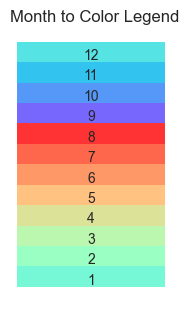

In [60]:
def colors_from_colormap(n, colormap, alpha=1):
    """Returns list of 'n' RGBA tuples that each define a single color based on the 
    matplotlib 'colormap' object (ie., 'plt.cm.Blues') provided
    Example Usage:
    colors_from_colormap(3, plt.cm.Blues, alpha=0.5)"""
    return [colormap(i/n, alpha=alpha) for i in range(1,n+1)]

colors_rainbow_12 = colors_from_colormap(12, plt.cm.rainbow , alpha=0.8)
# colors_rainbow_12 = colors_from_colormap(12, plt.cm.RdYlBu, alpha=0.8)
colors_7_red = np.roll(list(colors_rainbow_12), (2,2,2,2), axis=0)
colors_month = dict(zip(range(1,13), colors_7_red))
# colors_month_pale = dict(zip(range(1,13), colors_from_colormap(12, plt.cm.rainbow, alpha=0.3)))
colors_month_pale = dict(zip(range(1,13), colors_from_colormap(12, plt.cm.hsv, alpha=0.3)))
visualize_color_by_dictionary(colors_month, figsize=(2,3.5), title='Month to Color Legend')
# visualize_color_by_dictionary(colors_month_pale, figsize=(2,3.5), title='Month to Color Legend')

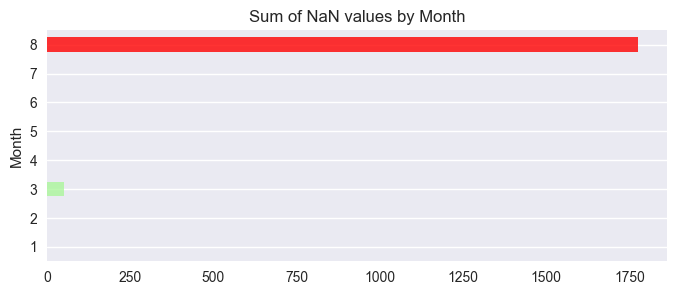

In [61]:
df.isna().sum(1).groupby(df.index.month)\
    .sum().plot.barh(figsize=(8,3),
     color=[colors_month[m] for m in df.index.month.unique()])
plt.ylabel('Month')
plt.title('Sum of NaN values by Month')
plt.grid(axis='x')
plt.show()

In [62]:
# when in time do remaining NaN's occur?
month_max_nan = df.isna().sum(1).groupby(df.index.month).sum().idxmax()

#### Visualize count of NaNs by Date

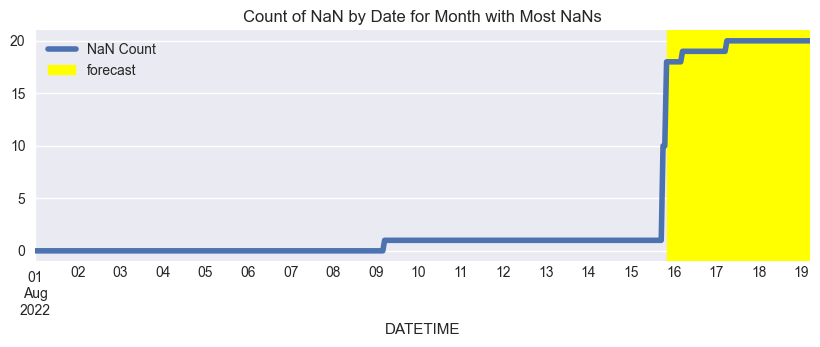

In [63]:
filter_max_month = df.index.month == month_max_nan
df.loc[filter_max_month].isna()\
        .sum(1).plot(figsize=(10,3), lw=4, label='NaN Count')
if month_max_nan in idx_forecast.month:
    plt.axvspan(df.index[df['forecast']][0], df.index[df['forecast']][-1],
            color='yellow', label='forecast')
plt.title('Count of NaN by Date for Month with Most NaNs')
plt.legend()
plt.show()

Are the features with NaN from the 'Actual' or 'Solving For' category? 

In [64]:
# list of columns defined as 'Solving For' in df_features
cols_actual_solve_for = df_features.loc[df_features['Actual'] | 
        df_features['Solving For']].index
len(cols_actual_solve_for), cols_actual_solve_for

(18,
 Index(['HB_NORTH (DALMP)', 'WZ_Coast (RTLOAD)', 'WZ_ERCOT (RTLOAD)',
        'WZ_East (RTLOAD)', 'WZ_FarWest (RTLOAD)', 'WZ_North (RTLOAD)',
        'WZ_NorthCentral (RTLOAD)', 'WZ_SouthCentral (RTLOAD)',
        'WZ_Southern (RTLOAD)', 'WZ_West (RTLOAD)', 'HB_NORTH (RTLMP)',
        'ERCOT (GENERATION_SOLAR_RT)', 'GR_COASTAL (WINDDATA)',
        'GR_ERCOT (WINDDATA)', 'GR_NORTH (WINDDATA)', 'GR_PANHANDLE (WINDDATA)',
        'GR_SOUTH (WINDDATA)', 'GR_WEST (WINDDATA)'],
       dtype='object', name='Feature'))

In [65]:
# verify that there are not columns in cols_w_nan that are not in cols_actual_solve_for
assert len(cols_actual_solve_for.difference(cols_w_nan)) == 0

Conclusions:  
1. The majority of the NaN values occur at the end of the historical data
2. all of the columns with NaN are in the 'Actual' or 'Solving For' category.   This implies that the last values of these columns are intentionally left undefined and are part of the forecasting objective.

__Leave the NaN values in the 'Forecast' period in the data set__

#### Do any columns have NaNs outside of the 'forecast' period?

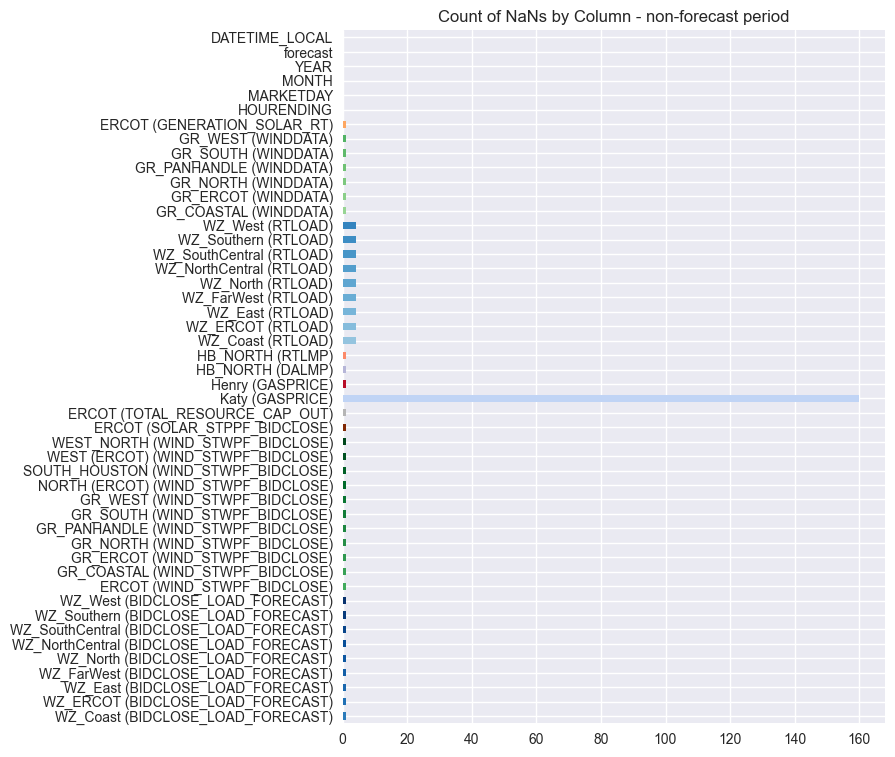

In [66]:
df.loc[~df['forecast']].isna().sum().plot.barh(figsize=(7,9), grid=True,
      color = colors_from_dict(colors_features, df.columns))
plt.title('Count of NaNs by Column - non-forecast period')
plt.show()

In [67]:
# interpolate any remaining NaN values in non-forecast time frame, 
# within limit of n_max_consec_nans_interp.
# df.loc[~df['forecast'], cols_not_time] = df.loc[~df['forecast'], cols_not_time]\
#                                             .interpolate(limit=n_max_consec_nans_interp)
for col in cols_not_time:
    try:
        df.loc[~df['forecast'], col] = pd.to_numeric(df.loc[~df['forecast'], col])\
                                        .interpolate(limit=None) 
    except:
        pass

In [68]:
# Do any out-of-forecast period records contain NaN?
# Hopefully an empty list is returned here - that is good
df.columns[df.loc[~df['forecast']].isna().sum().sort_values(ascending=False).gt(0) == True]
# df.loc[~df['forecast'], cols_not_time]\
#         .interpolate(limit=n_max_consec_nans_interp).isna().sum().sort_values(ascending=False).gt(0)

Index([], dtype='object')

In [69]:
cols_by_nan_count = df.loc[~df['forecast']].isna().sum().sort_values(ascending=False)
cols_unresolvable_nans = cols_by_nan_count.index[cols_by_nan_count > 0]
cols_by_nan_count = cols_by_nan_count[cols_by_nan_count.gt(0)].index.tolist()
df.loc[~df['forecast']].isna().sum()

WZ_Coast (BIDCLOSE_LOAD_FORECAST)           0
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)           0
WZ_East (BIDCLOSE_LOAD_FORECAST)            0
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)         0
WZ_North (BIDCLOSE_LOAD_FORECAST)           0
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)    0
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)    0
WZ_Southern (BIDCLOSE_LOAD_FORECAST)        0
WZ_West (BIDCLOSE_LOAD_FORECAST)            0
ERCOT (WIND_STWPF_BIDCLOSE)                 0
GR_COASTAL (WIND_STWPF_BIDCLOSE)            0
GR_ERCOT (WIND_STWPF_BIDCLOSE)              0
GR_NORTH (WIND_STWPF_BIDCLOSE)              0
GR_PANHANDLE (WIND_STWPF_BIDCLOSE)          0
GR_SOUTH (WIND_STWPF_BIDCLOSE)              0
GR_WEST (WIND_STWPF_BIDCLOSE)               0
NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)         0
SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)         0
WEST (ERCOT) (WIND_STWPF_BIDCLOSE)          0
WEST_NORTH (WIND_STWPF_BIDCLOSE)            0
ERCOT (SOLAR_STPPF_BIDCLOSE)                0
ERCOT (TOTAL_RESOURCE_CAP_OUT)    

In [70]:
df.loc[~df['forecast'], cols_by_nan_count[:8]].head()

Empty DataFrame
Columns: []
Index: [2022-01-01 07:00:00+00:00, 2022-01-01 08:00:00+00:00, 2022-01-01 09:00:00+00:00, 2022-01-01 10:00:00+00:00, 2022-01-01 11:00:00+00:00]

#### End of Attempts to Resolve out-of-forecast NaN values
The only columns that could still have NaNs at this point are columns with mixed date types.  NaN values could simply be Forward/Back filled.  Alternatively, more sophisticated methods could be used to attempt to replace NaN.  However, either method presents a risk of retaining corrupted data.  It is recommended to inspect the following columns. 

In [71]:
print(f'The following columns have NaN values that could not be resolved and may have mixed data types:\n'
     f'{", ".join(cols_unresolvable_nans)}\n\nThese columns will be dropped from the dataset')

The following columns have NaN values that could not be resolved and may have mixed data types:


These columns will be dropped from the dataset


#### Drop columns in cols_unresolvable_nans from dataset

In [72]:
df.drop(columns=cols_unresolvable_nans,
        inplace=True,errors='ignore')

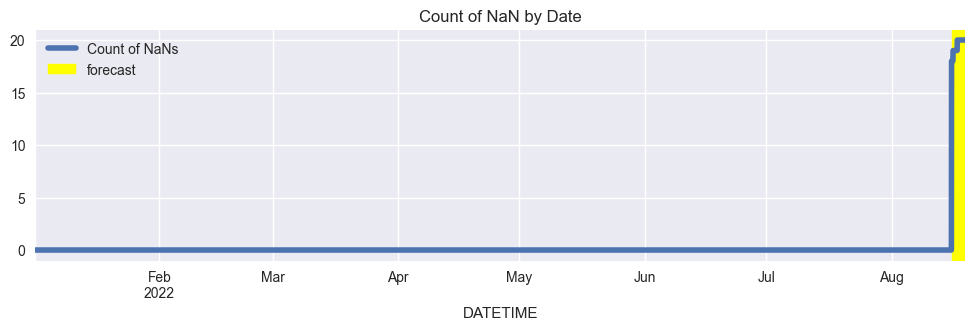

In [73]:
df.isna().sum(1).plot(figsize=(12,3), lw=4, label='Count of NaNs')
plt.title('Count of NaN by Date')
plt.axvspan(df.index[df['forecast']][0], df.index[df['forecast']][-1],
            color='yellow', label='forecast')
plt.legend()
plt.show()

#### Verify out-of-forecast data is free of all NaN values

In [74]:
assert df.loc[~df['forecast']].notnull().all().all()

#### Inspect df data types
It is likely that many numeric columns are shown as 'object' data type due to the presence of NaN values during the forecast period.  

In [75]:
df.dtypes.value_counts()

object                        44
int32                          2
bool                           1
datetime64[ns, US/Central]     1
dtype: int64

#### Separate In-Forecast records from Out-of-Forecast records 
This will make it possible to treat numeric data as numeric and have a 100% clean, non-null out-of-forecast dataset with appropriate data types.  
* In-forecast records -->  df_forecast  (flat file:  'ts.csv')
* Out-of-forecast records -->  df  (flat file:  'ts_forecast.csv')

In [76]:
display(df.shape)
df_forecast = df.loc[df['forecast']].copy()
df = df.loc[~df['forecast']].copy()

(5519, 48)

In [77]:
print(f'Shape of df (out-of-forecast): {df.shape}')
print(f'Shape of df_forecast (in-forecast): {df_forecast.shape}')

Shape of df (out-of-forecast): (5437, 48)
Shape of df_forecast (in-forecast): (82, 48)


#### Convert df data types to Numeric
Apply only to columns that are 'object' data type

In [78]:
for col in df.select_dtypes(include=[object]).columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

In [79]:
df.dtypes.value_counts()

float64                       42
int32                          2
object                         2
bool                           1
datetime64[ns, US/Central]     1
dtype: int64

In [80]:
# does it make sense that the following columns are NOT numeric?
df.select_dtypes(exclude=[float, int]).head(3)

MARKETDAY    MONTH  forecast  \
DATETIME                                                   
2022-01-01 07:00:00+00:00  2022-01-01  JANUARY     False   
2022-01-01 08:00:00+00:00  2022-01-01  JANUARY     False   
2022-01-01 09:00:00+00:00  2022-01-01  JANUARY     False   

                                     DATETIME_LOCAL  
DATETIME                                             
2022-01-01 07:00:00+00:00 2022-01-01 01:00:00-06:00  
2022-01-01 08:00:00+00:00 2022-01-01 02:00:00-06:00  
2022-01-01 09:00:00+00:00 2022-01-01 03:00:00-06:00

## Visualization

#### Pairplot of Target Features

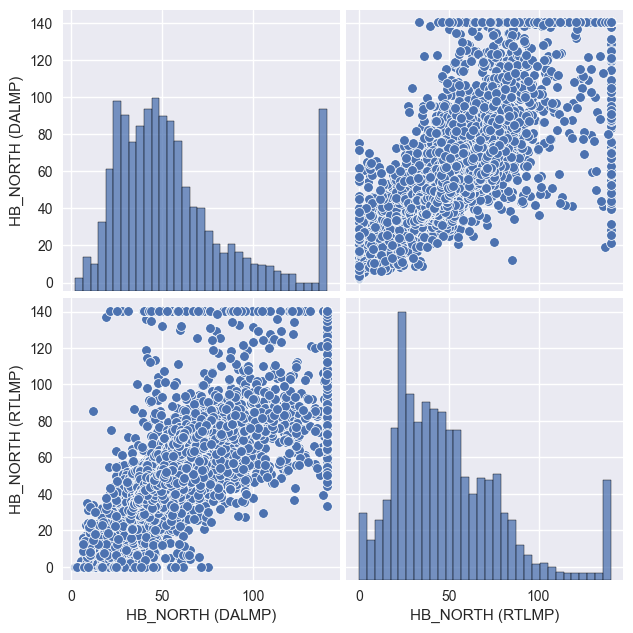

In [81]:
targets_95th_pctile = df[cols_target].stack().quantile(0.95)
data_ = df[cols_target].clip(0, targets_95th_pctile)
# fig, ax = plt.subplots()
g= sns.pairplot(data_, height=3.2)
# sns.title(f'Pairplot of {", ".join(cols_target)}')
fig.suptitle(f'Pairplot of {", ".join(cols_target)}')
plt.show()

#### Line plot of Target Features

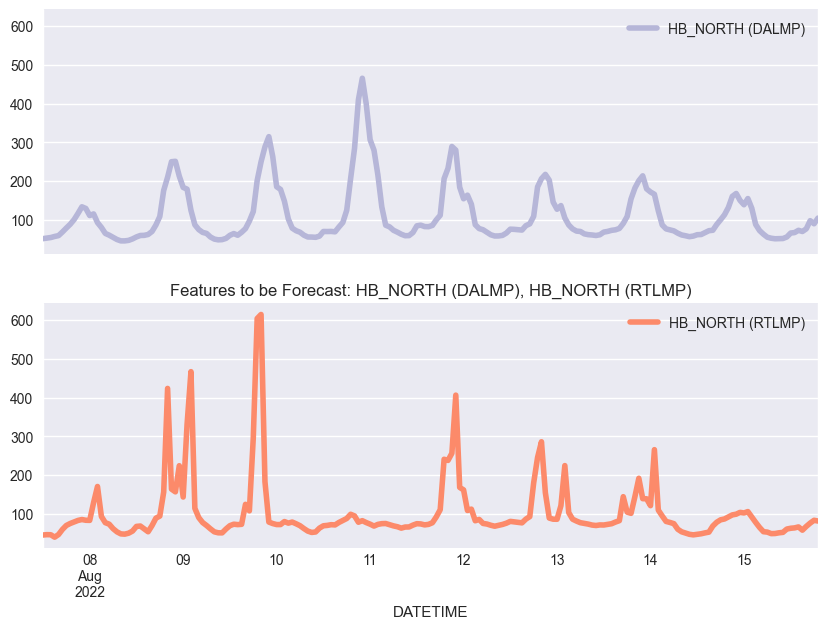

In [82]:
df[cols_target].iloc[-200:].plot(subplots=True, sharey=True,
     figsize=(10,7), lw=4,  color = colors_target,
    grid=True)
plt.title(f'Features to be Forecast: {", ".join(cols_target)}')
plt.show()

### Calculate Spearman (Rank) Correlations

In [127]:
df_corr = df.loc[~df['forecast']].select_dtypes(exclude='object')
df_corr = df_corr.corr(method='spearman')\
            [cols_target].join(df_features[['Feature Type',
            'Region']]).loc[df_features.index.difference(cols_target)]
df_corr.sort_values(by=cols_target, inplace=True, ascending=[False, False])
df_corr.head()

C:\Users\user\AppData\Local\Temp\ipykernel_1856\3413301968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_corr.corr(method='spearman')\


HB_NORTH (DALMP)  HB_NORTH (RTLMP)  \
Feature                                                                    
WZ_Southern (RTLOAD)                          0.799590          0.732162   
WZ_Coast (RTLOAD)                             0.798733          0.743927   
WZ_SouthCentral (RTLOAD)                      0.795687          0.742907   
WZ_Coast (BIDCLOSE_LOAD_FORECAST)             0.794506          0.719400   
WZ_Southern (BIDCLOSE_LOAD_FORECAST)          0.791559          0.717911   

                                     Feature Type        Region  
Feature                                                          
WZ_Southern (RTLOAD)                       Demand         south  
WZ_Coast (RTLOAD)                          Demand         coast  
WZ_SouthCentral (RTLOAD)                   Demand  southcentral  
WZ_Coast (BIDCLOSE_LOAD_FORECAST)          Demand         coast  
WZ_Southern (BIDCLOSE_LOAD_FORECAST)       Demand         south

#### Line Plot of Ten Most Correlated Numeric Features vs Target Features

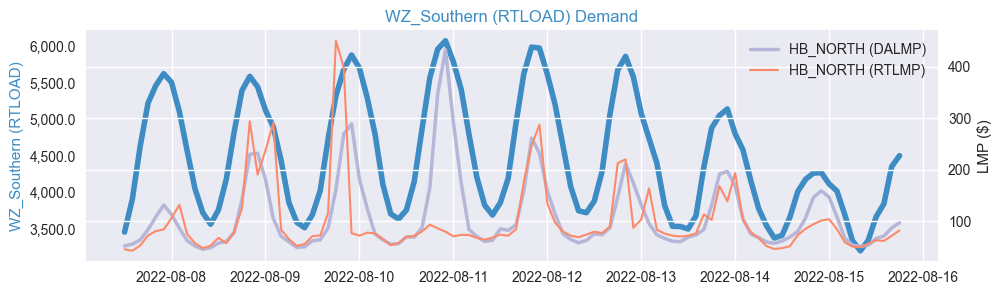

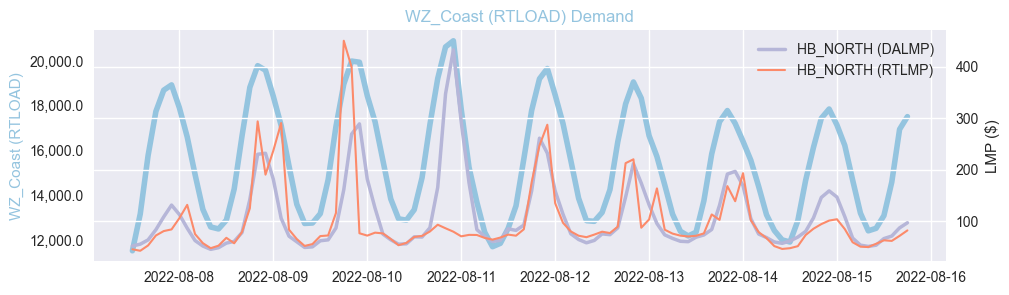

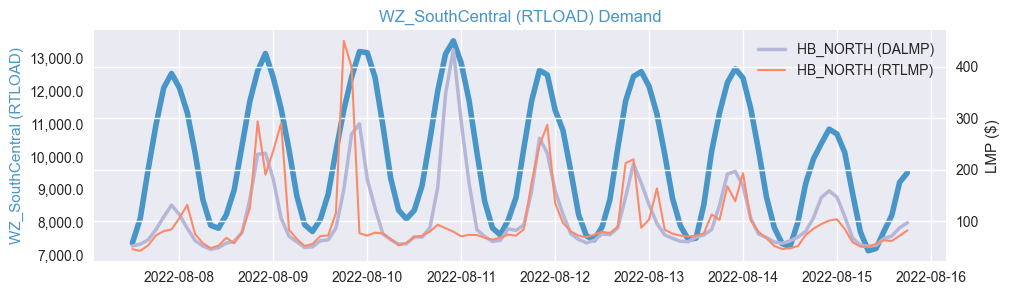

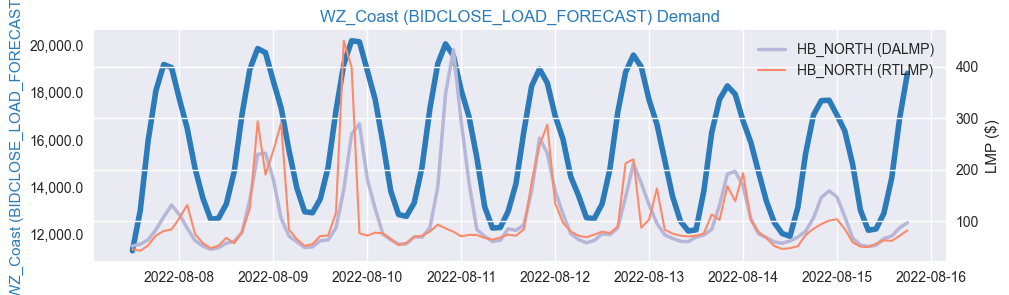

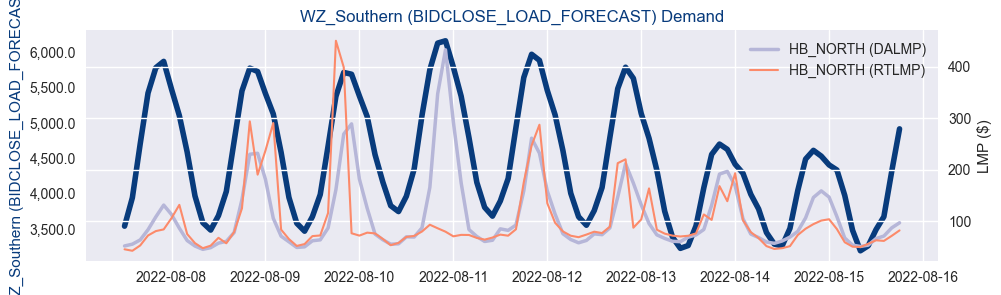

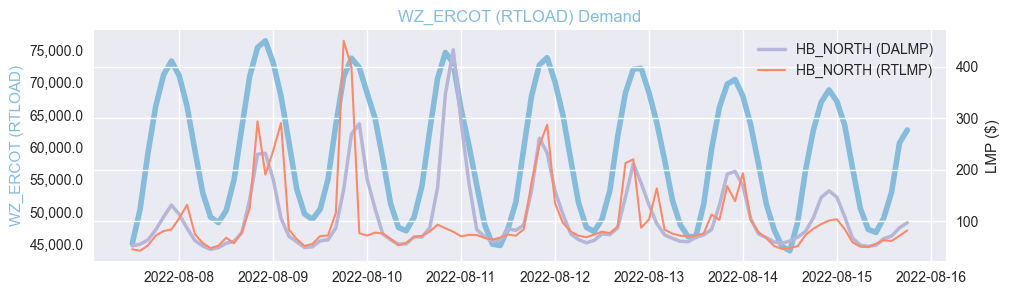

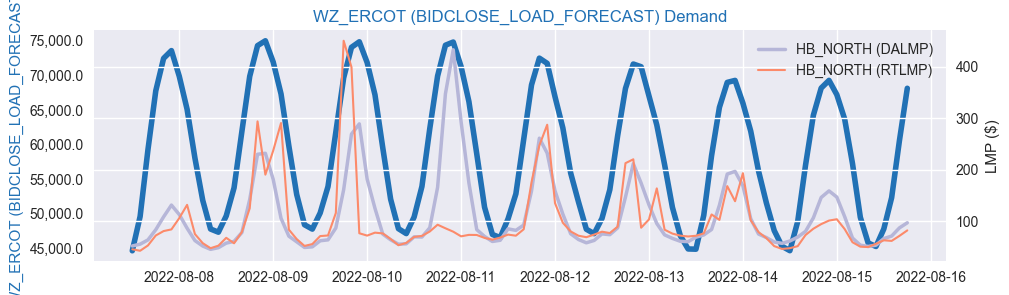

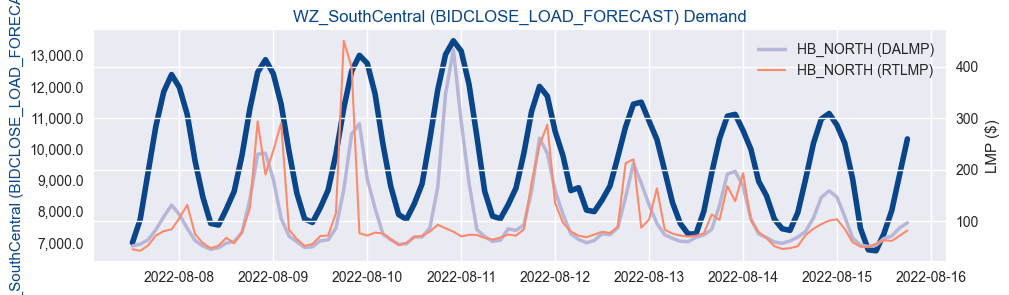

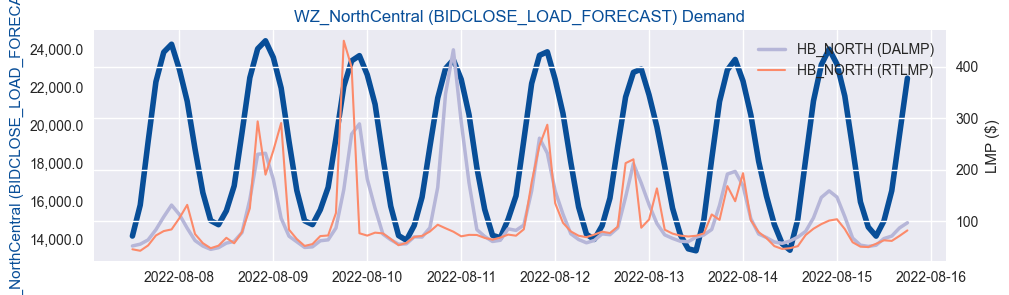

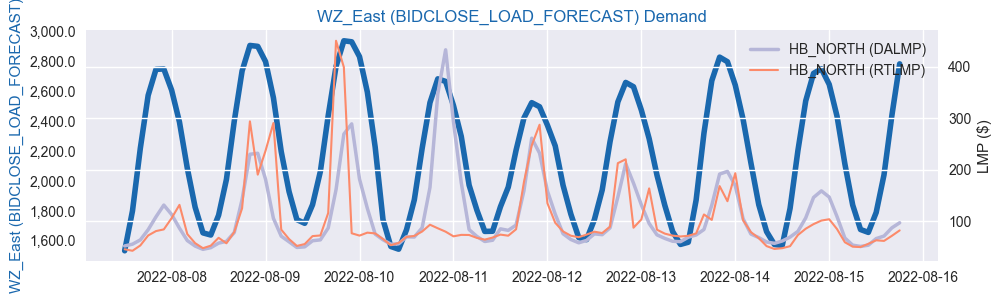

In [129]:
# for col_feature_ in df_features.index.difference(cols_target):
for col_feature_ in df_corr.index.tolist()[:10]:
    feature_type_ = df_features['Feature Type'].loc[col_feature_]
#     select data_ to plot and down sample to reduce notebook file size
    data_ = df[[col_feature_] + cols_target].iloc[-200:].resample('2H').mean()
    fig, ax = plt.subplots(figsize=(11,3))
    ax.plot(data_[col_feature_], lw=4, color=colors_features[col_feature_])
#     ax.axvspan(idx_forecast[0], idx_forecast[-1])  #forecast period - Not used here
    ax.set_title(f'{col_feature_} {feature_type_}', color=colors_features[col_feature_])
    ax.set_ylabel(col_feature_, color=colors_features[col_feature_])
    ax.grid(axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
    ax_twinx = ax.twinx()
    ax_twinx.plot(data_[cols_target[0]], lw=2.5,
                  color=colors_target[cols_target[0]], label=cols_target[0])
    ax_twinx.plot(data_[cols_target[1]], lw=1.5,
                  color=colors_target[cols_target[1]], label=cols_target[1])
    ax_twinx.set_ylabel('LMP ($)')
    ax_twinx.legend()
    
    
    plt.show()

In [130]:
df_corr.index

Index(['WZ_Southern (RTLOAD)', 'WZ_Coast (RTLOAD)', 'WZ_SouthCentral (RTLOAD)',
       'WZ_Coast (BIDCLOSE_LOAD_FORECAST)',
       'WZ_Southern (BIDCLOSE_LOAD_FORECAST)', 'WZ_ERCOT (RTLOAD)',
       'WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)',
       'WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)',
       'WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)',
       'WZ_East (BIDCLOSE_LOAD_FORECAST)',
       'WZ_FarWest (BIDCLOSE_LOAD_FORECAST)',
       'WZ_West (BIDCLOSE_LOAD_FORECAST)', 'WZ_East (RTLOAD)',
       'WZ_FarWest (RTLOAD)', 'WZ_NorthCentral (RTLOAD)', 'Katy (GASPRICE)',
       'WZ_North (RTLOAD)', 'Henry (GASPRICE)',
       'WZ_North (BIDCLOSE_LOAD_FORECAST)', 'WZ_West (RTLOAD)',
       'ERCOT (SOLAR_STPPF_BIDCLOSE)', 'ERCOT (GENERATION_SOLAR_RT)',
       'GR_COASTAL (WINDDATA)', 'GR_COASTAL (WIND_STWPF_BIDCLOSE)',
       'SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)', 'GR_SOUTH (WIND_STWPF_BIDCLOSE)',
       'GR_SOUTH (WINDDATA)', 'GR_ERCOT (WINDDATA)',
       'GR_ERCOT (WIND_STWPF_BIDCLOSE)', 'ERCOT (W

#### Scatter Plots of Top 10 and Bottom 5 Numeric Features vs Target Features by Rank Correlation

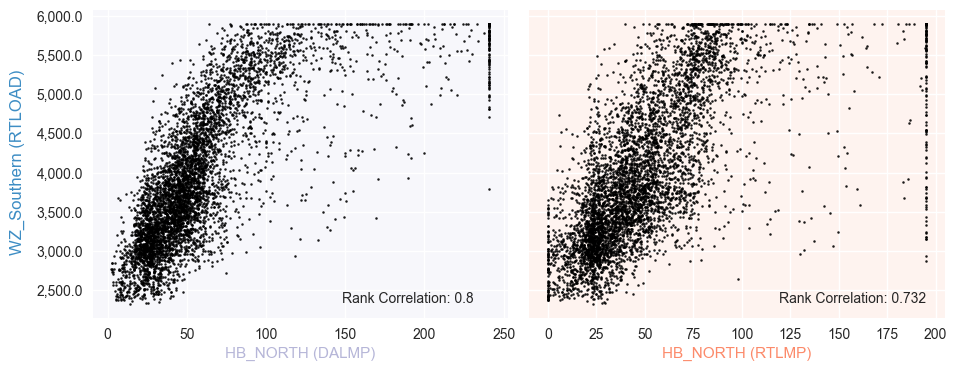

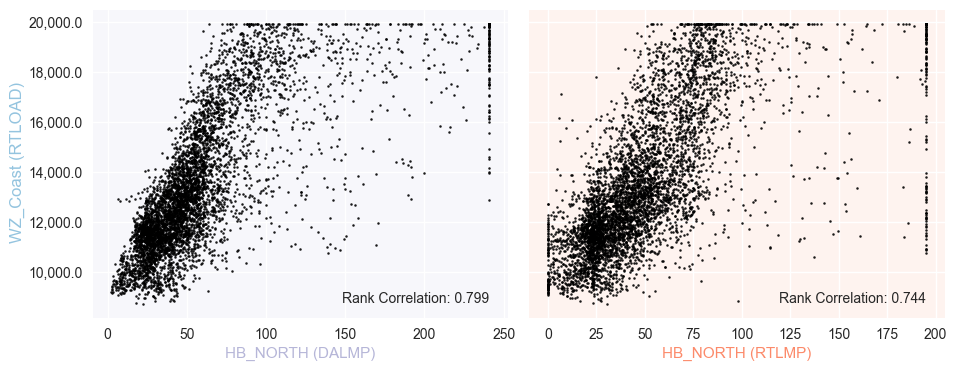

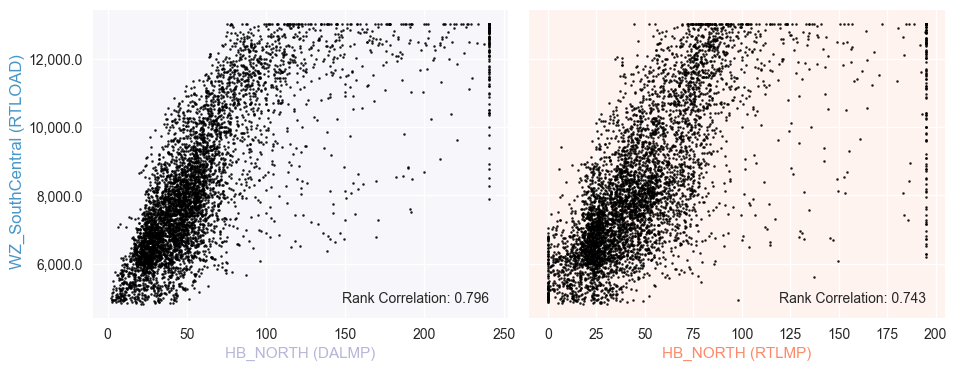

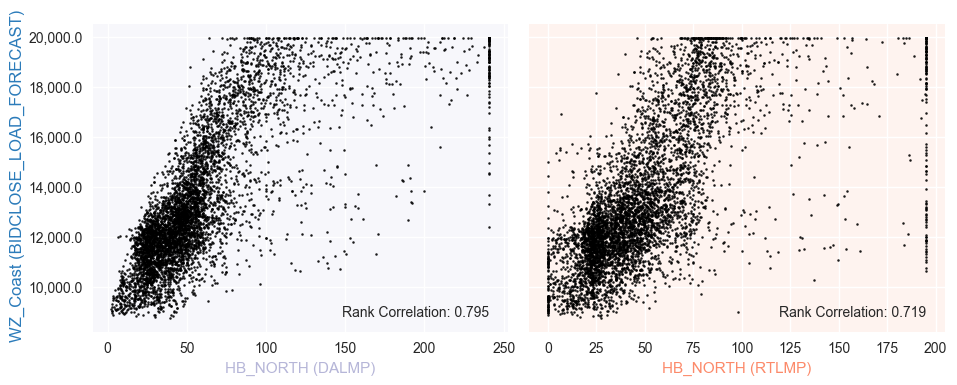

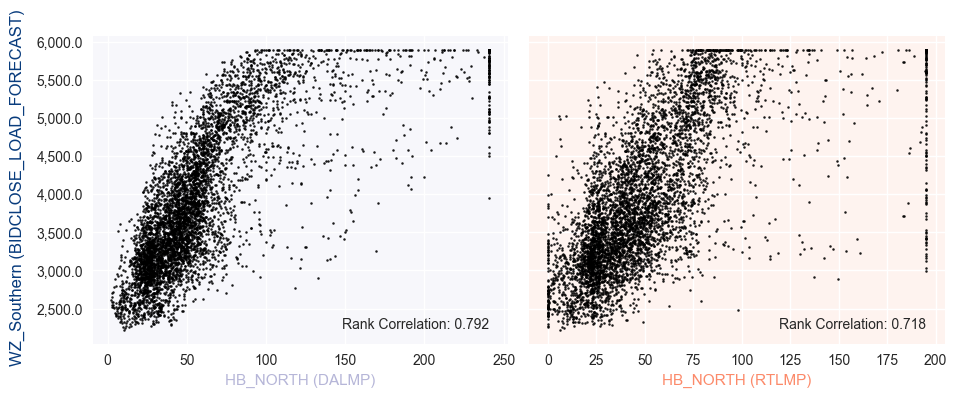

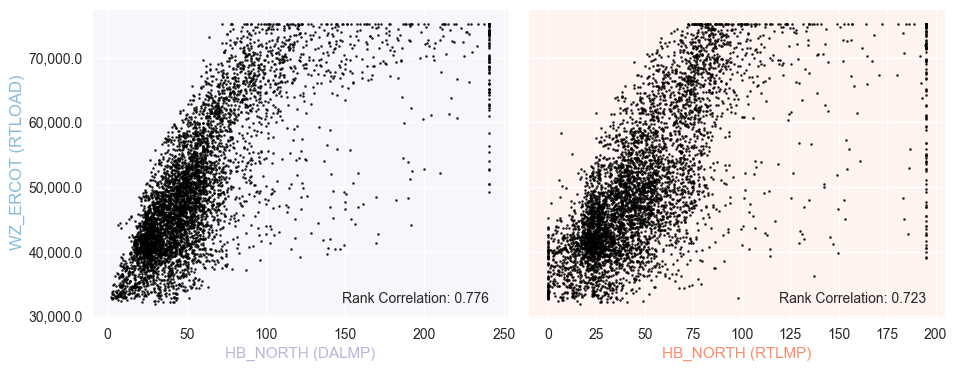

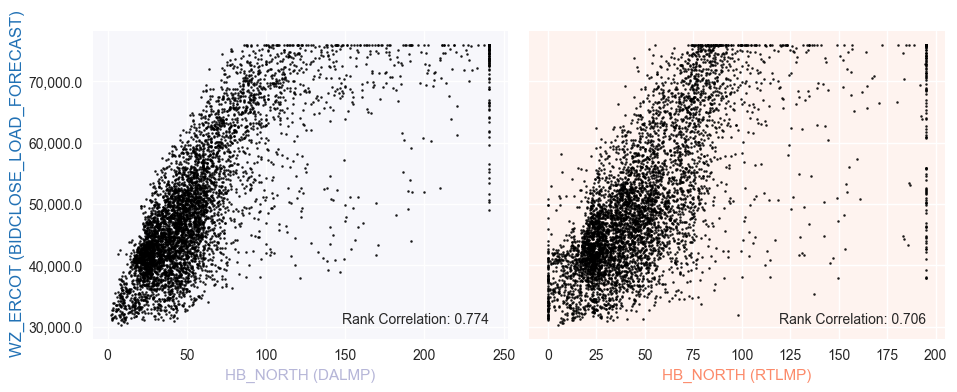

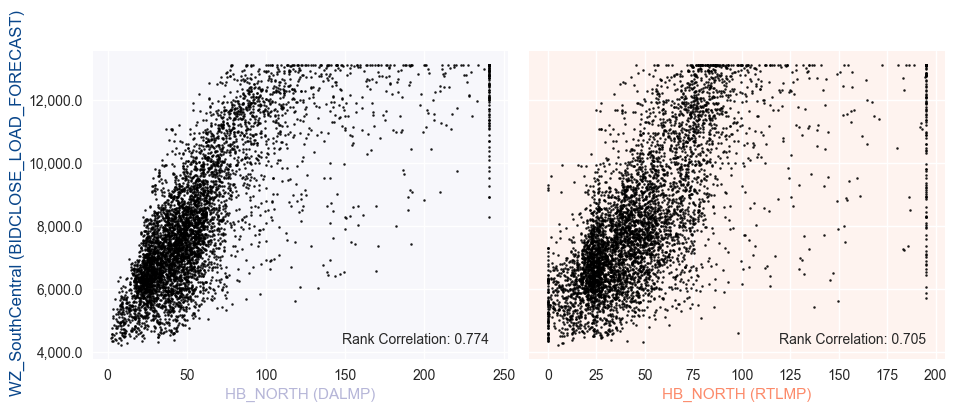

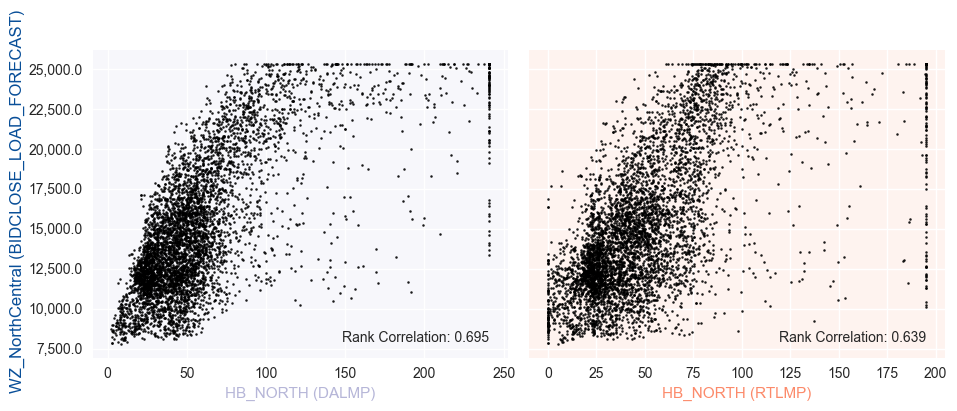

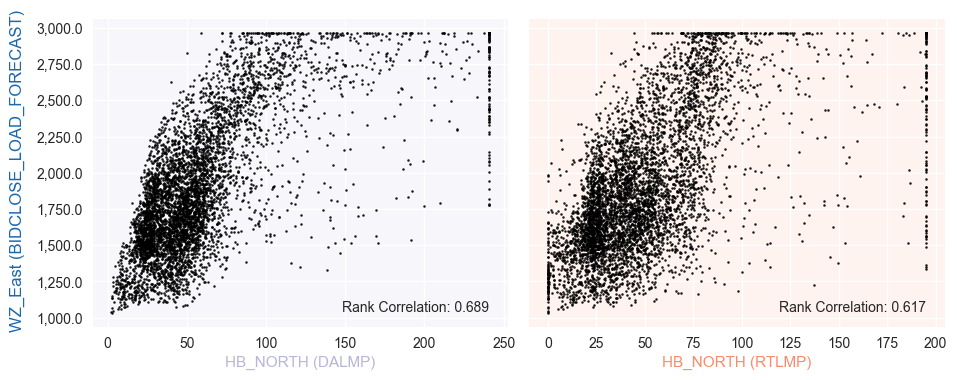

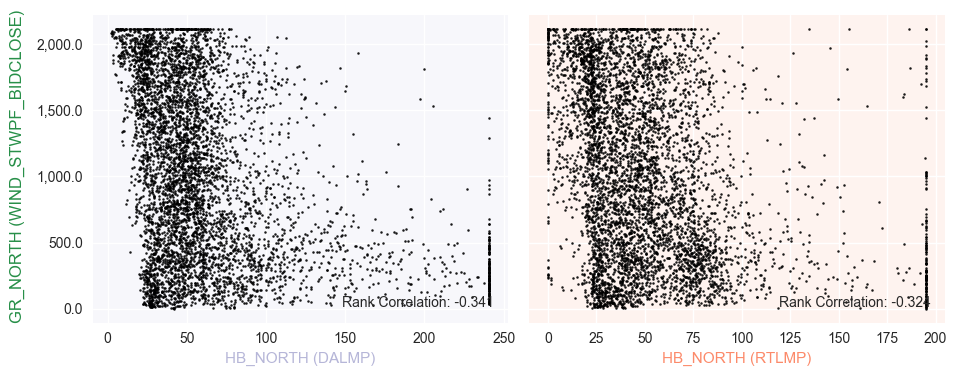

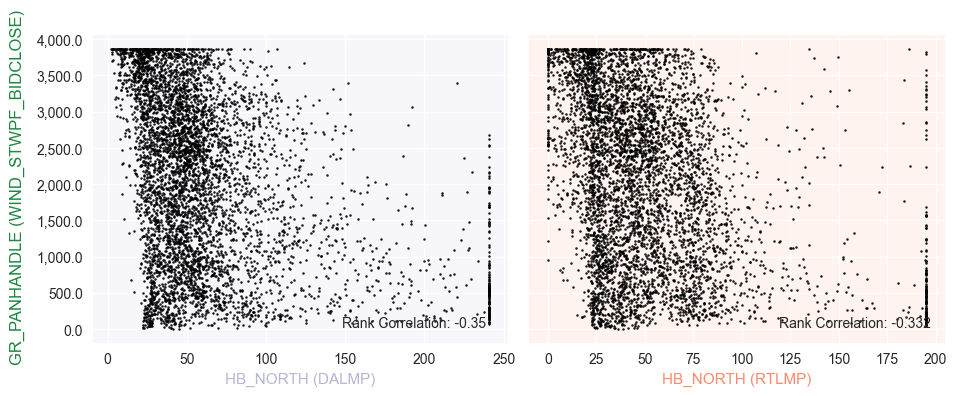

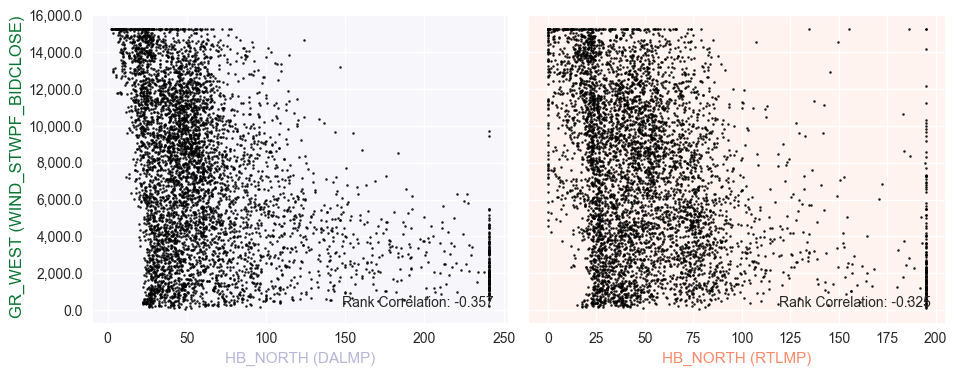

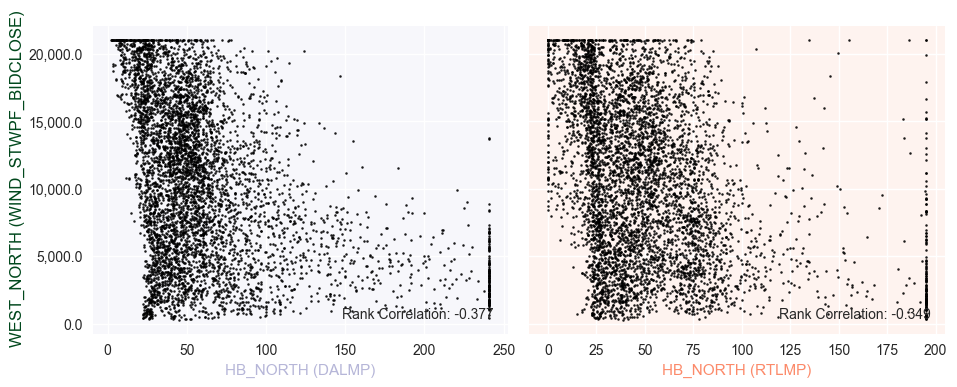

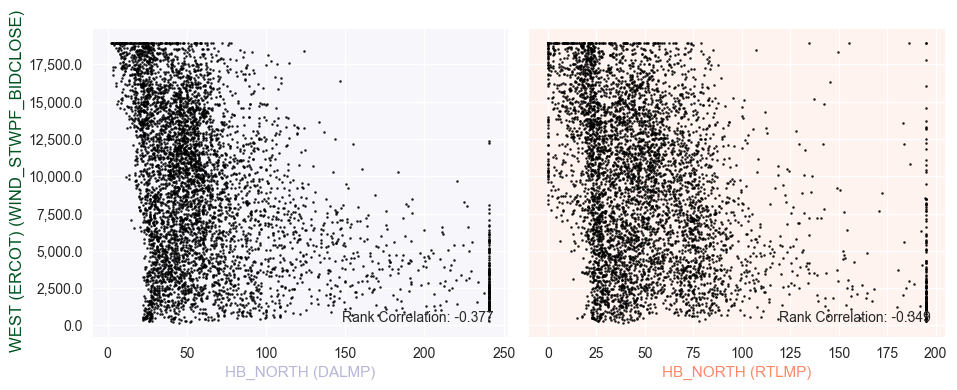

In [131]:
# for col_feature_ in list(df_features.index.difference(cols_target))[:3] :
# for col_feature_ in df_features.index.difference(cols_target) :
# for col_feature_ in df_corr.index.tolist():
for col_feature_ in df_corr.index.tolist()[:10] + df_corr.index.tolist()[-5:]:
    _, col_0_corr_, col_1_corr_ = df[[col_feature_] + cols_target]\
                    .corr(method='spearman').loc[col_feature_].values
    fig, ax = plt.subplots(1,2, figsize=(11,4), sharey=True, gridspec_kw={'wspace': 0.05} )
    y_ = df[col_feature_].clip(0, df[col_feature_].quantile(0.975)).values
#     fig.suptitle(col_feature_)
    fig.supylabel(col_feature_, x=0.05, color = colors_features[col_feature_])
    for idx_, col_target_ in enumerate(cols_target):
        _, corr_ = df[[col_feature_, col_target_]].corr(method='spearman')\
                .round(3).loc[col_feature_].values
        x_ = df[col_target_].clip(0,
              df[col_target_].quantile(0.975)).values 
        ax[idx_].scatter(x=x_, y=y_,
                  color='black', s=2, alpha=0.9)
        ax[idx_].grid(axis='both', color='white')
#         ax[idx_].set_aspect('equal')
        ax[idx_].set_xlabel(col_target_, color=colors_target[col_target_])
        ax[idx_].text(0.6, 0.05, f'Rank Correlation: {corr_}',
                      transform=ax[idx_].transAxes)
        ax[idx_].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
        ax[idx_].set_facecolor(colors_target_light[col_target_])
    plt.show()

#### Quality Check df and save to disk

In [94]:
# assert df.notnull().any().any()
assert not df.index.has_duplicates
assert not df.columns.has_duplicates
assert df.notnull().all().all()

# save to disk
file_ts_out = data_dir / 'ts.csv'
df.to_csv(file_ts_out)
assert file_ts_out.is_file()
print(f'Processed out-of-forecast data saved to'
      f':\n{file_ts_out}')

Processed out-of-forecast data saved to:
C:\Users\user\OneDrive\python_envs\ERCOT_electricity_price_forecast\data\ts.csv


#### Quality Check df_forecast and save to disk

In [95]:
# assert df_forecast.notnull().any().any()
assert not df_forecast.index.has_duplicates
assert not df_forecast.columns.has_duplicates

# save to disk
file_ts_forecast_out = data_dir / 'ts_forecast.csv'
df_forecast.to_csv(file_ts_forecast_out)
assert file_ts_forecast_out.is_file()
print(f'Processed in-forecast data saved to'
      f':\n{file_ts_forecast_out}')

Processed in-forecast data saved to:
C:\Users\user\OneDrive\python_envs\ERCOT_electricity_price_forecast\data\ts_forecast.csv


### Inspect Correlations

In [96]:
df_corr = df.loc[~df['forecast']].select_dtypes(exclude='object')
df_corr = df_corr.corr(method='spearman')\
            [cols_target].join(df_features[['Feature Type',
            'Region']]).loc[df_features.index.difference(cols_target)]
df_corr.head()

C:\Users\user\AppData\Local\Temp\ipykernel_1856\3498967210.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_corr.corr(method='spearman')\


HB_NORTH (DALMP)  HB_NORTH (RTLMP)  \
Feature                                                              
ERCOT (GENERATION_SOLAR_RT)             0.322369          0.234927   
ERCOT (SOLAR_STPPF_BIDCLOSE)            0.327534          0.234577   
ERCOT (TOTAL_RESOURCE_CAP_OUT)         -0.317647         -0.345264   
ERCOT (WIND_STWPF_BIDCLOSE)            -0.293481         -0.270259   
GR_COASTAL (WINDDATA)                   0.206640          0.168392   

                               Feature Type    Region  
Feature                                                
ERCOT (GENERATION_SOLAR_RT)           Solar     solar  
ERCOT (SOLAR_STPPF_BIDCLOSE)          Solar     stppf  
ERCOT (TOTAL_RESOURCE_CAP_OUT)      Outages  resource  
ERCOT (WIND_STWPF_BIDCLOSE)            Wind     stwpf  
GR_COASTAL (WINDDATA)                  Wind     coast

In [97]:
df_corrmap = df_corr.groupby(['Feature Type', 'Region'])[cols_target].mean().mean(axis=1)\
                .reset_index().rename(columns={0:'Mean Correlation'})
df_corrmap_mean = pd.crosstab(df_corrmap['Feature Type'], df_corrmap['Region'],
                              df_corrmap['Mean Correlation'],
                               aggfunc='mean')
df_corrmap_mean

Region            None     coast      east     ercot  farwest   houston  \
Feature Type                                                              
Demand             NaN  0.764141  0.655949  0.744506  0.68416       NaN   
Fuel Price    0.616634       NaN       NaN       NaN      NaN       NaN   
Outages            NaN       NaN       NaN       NaN      NaN       NaN   
Solar              NaN       NaN       NaN       NaN      NaN       NaN   
Wind               NaN  0.154531       NaN -0.289499      NaN  0.072481   

Region           north  northcentral  panhandle  resource     solar     south  \
Feature Type                                                                    
Demand        0.603260      0.663689        NaN       NaN       NaN  0.760305   
Fuel Price         NaN           NaN        NaN       NaN       NaN       NaN   
Outages            NaN           NaN        NaN -0.331456       NaN       NaN   
Solar              NaN           NaN        NaN       NaN  0.278648       NaN   
Wind         -0.335195           NaN  -0.349478       NaN       NaN -0.066515   

Region        southcentral     stppf     stwpf      west  
Feature Type                                              
Demand            0.754391       NaN       NaN  0.595862  
Fuel Price             NaN       NaN       NaN       NaN  
Outages                NaN       NaN       NaN       NaN  
Solar                  NaN  0.281056       NaN       NaN  
Wind                   NaN       NaN -0.321737 -0.346362

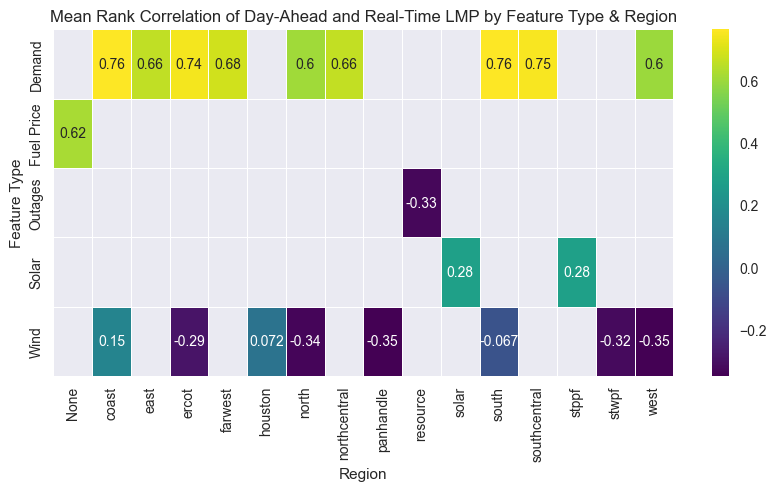

In [98]:
fig, ax = plt.subplots(figsize=(10,4.5))
sns.heatmap(df_corrmap_mean, annot=True, ax=ax, cmap='viridis', linewidth=0.5)
ax.set_title('Mean Rank Correlation of Day-Ahead and Real-Time LMP by Feature Type & Region')
ax.grid(visible=False)
plt.show()


In [99]:
# data_ = df_corr[cols_target].mean(axis=1)
# df_corr_feature = df_corr.groupby('Feature Type').mean()
df_corr_feature = df_corr.groupby('Feature Type')[cols_target].mean()
df_corr_feature

HB_NORTH (DALMP)  HB_NORTH (RTLMP)
Feature Type                                    
Demand                0.719521          0.664093
Fuel Price            0.637158          0.596109
Outages              -0.317647         -0.345264
Solar                 0.324952          0.234752
Wind                 -0.216770         -0.217695

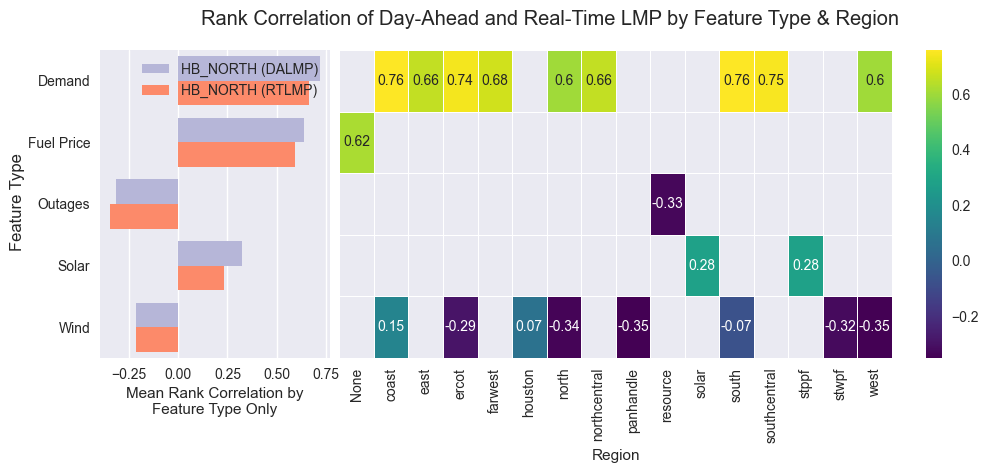

In [124]:
fig, [ax_l, ax_r] = plt.subplots(1,2, width_ratios=[1,3], figsize=(12,4),
                                 sharey=True, gridspec_kw={'wspace': 0.02})

# right axis
sns.heatmap(df_corrmap_mean.round(2), annot=True, ax=ax_r, cmap='viridis', linewidth=0.65)
# ax_r.set_title('Mean Rank Correlation of Day-Ahead and Real-Time LMP by Feature Type & Region')
ax_r.grid(visible=False)
ax_r.set_ylabel('')


# left axis
bar_height = 0.4
y_pos = ax_r.get_yticks()
# for col_target_ in df_corr_feature.columns:
bar1 = ax_l.barh(y_pos - bar_height/2, df_corr_feature[cols_target[0]], bar_height,
                 label=cols_target[0], color=colors_target[cols_target[0]])
bar2 = ax_l.barh(y_pos + bar_height/2, df_corr_feature[cols_target[1]], bar_height,
                 label=cols_target[1], color=colors_target[cols_target[1]])
ax_l.set_xlabel('Mean Rank Correlation by\nFeature Type Only')
ax_l.legend()
ax_l.grid(axis='y')
fig.supylabel('Feature Type', x=0.05)
fig.suptitle('Rank Correlation of Day-Ahead and Real-Time LMP by Feature Type & Region', ha='center' )
plt.show()

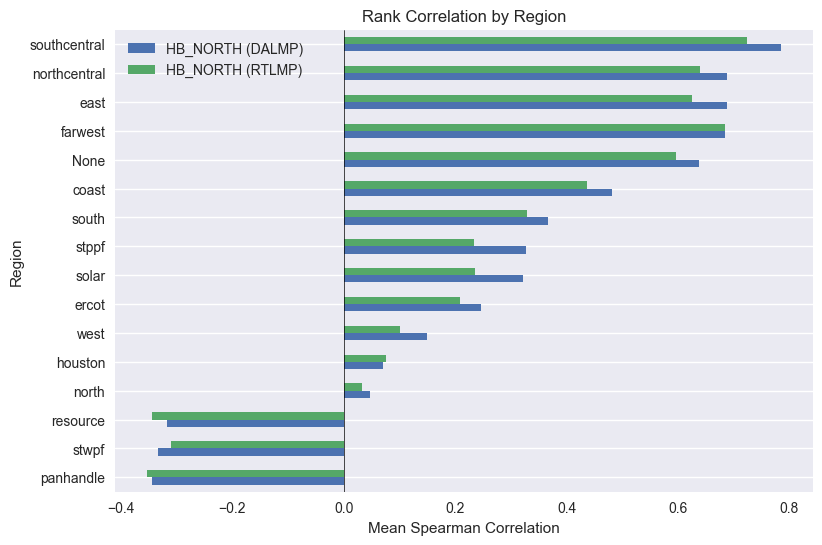

In [107]:
df_corr_region = df_corr.groupby('Region')[cols_target].mean()\
    .sort_values(cols_target[0])
df_corr_region.plot.barh(figsize=(9,6))
plt.axvline(0, color='black', lw=0.5)
plt.title('Rank Correlation by Region')
plt.xlabel('Mean Spearman Correlation')
plt.grid(axis='x')
plt.show()

### Observations:
1. RT LMP is almost never more correlated with the feature collection than DA LMP, except in the case of 'outages'
2. LMP shows the highest rank correlation with 'Demand' feature types, and this appears to be a logical insight.

#### Outage Exploration - Brief look at the impact of Outages
As represented by 'ERCOT (TOTAL_RESOURCE_CAP_OUT)'

In [116]:
cols_outages = df_features[df_features['Feature Type'] == 'Outages'].index.tolist()
col_outage_0 = cols_outages[0]
col_outage_0

'ERCOT (TOTAL_RESOURCE_CAP_OUT)'

In [121]:
# identify period with most outages 
idx_outage_peak = df[col_outage_0].idxmax()
# slice_outage_week = slice(idx_outage_peak - pd.offsets.Day(4), idx_outage_peak + pd.offsets.Day(4))
slice_outage_period = slice(idx_outage_peak - pd.offsets.Day(14), idx_outage_peak + pd.offsets.Day(14))

In [122]:
df.loc[slice_outage_period, cols_outages + cols_target]  

ERCOT (TOTAL_RESOURCE_CAP_OUT)  HB_NORTH (DALMP)  \
DATETIME                                                                      
2022-04-05 16:00:00+00:00                         24189.0             30.00   
2022-04-05 17:00:00+00:00                         24189.0             30.88   
2022-04-05 18:00:00+00:00                         24272.0             37.73   
2022-04-05 19:00:00+00:00                         24273.0             38.51   
2022-04-05 20:00:00+00:00                         24333.0             42.66   
...                                                   ...               ...   
2022-05-03 12:00:00+00:00                         20012.0             57.30   
2022-05-03 13:00:00+00:00                         20012.0             56.27   
2022-05-03 14:00:00+00:00                         20012.0             49.43   
2022-05-03 15:00:00+00:00                         20095.0             47.07   
2022-05-03 16:00:00+00:00                         20165.0             55.15   

                           HB_NORTH (RTLMP)  
DATETIME                                     
2022-04-05 16:00:00+00:00           32.8725  
2022-04-05 17:00:00+00:00           35.5025  
2022-04-05 18:00:00+00:00           37.4900  
2022-04-05 19:00:00+00:00           36.3025  
2022-04-05 20:00:00+00:00           42.8500  
...                                     ...  
2022-05-03 12:00:00+00:00           45.7400  
2022-05-03 13:00:00+00:00           47.2025  
2022-05-03 14:00:00+00:00           42.0225  
2022-05-03 15:00:00+00:00           45.0900  
2022-05-03 16:00:00+00:00           63.4325  

[673 rows x 3 columns]

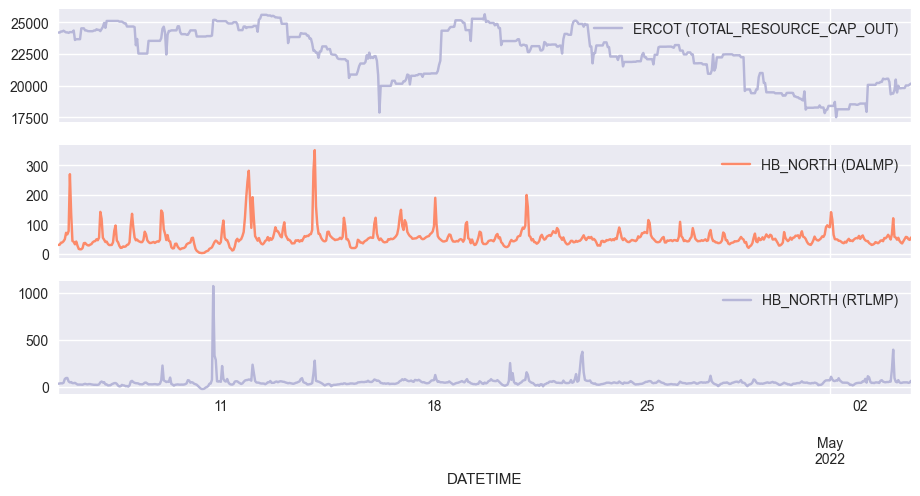

In [123]:
df.loc[slice_outage_period, cols_outages + cols_target]\
    .plot(subplots=True, color = [colors_features[c] for c in cols_target])
plt.show()

# END
Proceed to next script "2 - Descriptive Statistics & Data Augmentation".